# 1 SDS on AU 111 6x4x1 LAMMPS

This notebook contains a set of code snippets and functions, supporting analysis of LAMMPS output.
Exemplarily, the minimization, equilibration and production trajectories of one dodecyl sulfate ion in
the vicinity of a 100 gold layer are investigated.

With the help of numpy, pandas and matplotlib, LAMMPS output energy conbtributions are evaluated and plotted.
With the help of ase, parmed, nglview and ipywidgets, trajectories are visulized.

With the help of ase and asap, radial distribution functions, distances, displacements and diffusivities are evaluated.

## 1. Header

### 1.1. Jupyter Notebook-related "magic" commands

In [2]:
## preferred installation method for netcdf on NEMO locally:
# module load mpi/openmpi/2.1-gnu-5.2
# module load {...}
# export CPPFLAGS="${CPPFLAGS} -I${MPI_INC_DIR}"
# export LDFLAGS="${LDFLAGS} -L${MPI_LIB_DIR}"
# pip install --user netCDF4

## alternatively:
# pip install --user --global-option=build_ext --global-option="-L${MPI_INC_DIR}" netCDF4

In [3]:
%lsmagic # notebook commands

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python

In [4]:
# list environment variables, like bash's 'printenv'
%env

{'BASH_FUNC_module()': '() {  eval $(/opt/bwhpc/common/admin/modules/module-wrapper/modulecmd bash $*)\n}',
 'CC': 'gcc',
 'CFLAGS': '-O3 -fPIC',
 'CLICOLOR': '1',
 'CMAKE_BIN_DIR': '/opt/bwhpc/common/devel/cmake/3.9.0/bin',
 'CMAKE_DOC_DIR': '/opt/bwhpc/common/devel/cmake/3.9.0/doc',
 'CMAKE_HOME': '/opt/bwhpc/common/devel/cmake/3.9.0',
 'CMAKE_MAN_DIR': '/opt/bwhpc/common/devel/cmake/3.9.0/man',
 'CMAKE_VERSION': '3.9.0',
 'CPATH': '/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_modules/lammps/16Mar18-gnu-5.2-openmpi-2.1/include:/opt/bwhpc/common/compiler/intel/2017.7.259/compilers_and_libraries/linux/mkl/include',
 'CPPFLAGS': '-I/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_modules/lammps/16Mar18-gnu-5.2-openmpi-2.1/include',
 'CXX': 'g++',
 'CXXFLAGS': '-O3 -fPIC',
 'C_INCLUDE_PATH': '/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_modules/libxc/2.2.0/include',
 'DISPLAY': 'localhost:21.0',
 'ENV': '/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17',
 'F77': 'gfortran',

In [5]:
%load_ext memory_profiler

In [6]:
# for some reason, nglview sometimes changes into some temporary directory
# therefore ALWAY use absolute filenames and paths
# %cd /work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/sds/201806/1_SDS_on_AU_100_1x4x4/

### 1.2. Imports

In [7]:
# system basics
import os
absolute_prefix = os.getcwd() # might be handy to get back to the initial working directory at any point
os.sep # '\' ond windows and '/' on unix-like

'/'

In [8]:
# data analysis 
import pandas as pd 
import numpy as np

import ase
from asap3.analysis.rdf import RadialDistributionFunction

# file formats, input - output
import ase.io
from ase.io import read
import parmed as pmd

# visualization
from ase.visualize import view
import nglview as nv
import matplotlib.pyplot as plt
import ipywidgets # just for jupyter notebooks

### 1.3. Global options

In [9]:
%matplotlib inline

In [10]:
# matplotlib settings

# expecially for presentation, larger font settings for plotting are recommendable
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titlex

plt.rcParams["figure.figsize"] = (11,7) # the standard figure size

In [11]:
# numpy truncates the output of large array above the treshold length
np.set_printoptions(threshold=10) 

### 1.4. Definition of helper functions

In [146]:
# conversion units, only for better readability
fs = 1e-15 # s
ps = 1e-12 # s

In [147]:
AA = 1e-10 # m

In [148]:
def fullprint(*args, **kwargs):
    """prints a long numpy array without altering numpy treshold options permanently"""
    from pprint import pprint
    opt = np.get_printoptions()
    np.set_printoptions(edgeitems=3,infstr='inf', 
        linewidth=75, nanstr='nan', precision=8,
        suppress=False, threshold=100000, formatter=None)
    pprint(*args, **kwargs)
    np.set_printoptions(**opt)

In [149]:
def runningMeanFast(x, N):
    """a quick way to compute the running or rolling mean on a numpy array"""
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

In [150]:
def running_mean(x, N):
    """another quick way to compute the running or rolling mean on a numpy array"""
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [151]:
def subplotPosition(rows,cols):
    """generator for subplot positions"""
    for p in range(0,rows*cols):
        yield rows*100+cols*10+p+1

def addSubplot(x, y,
               title=None, xlabel=None, ylabel=None, legend=None,
               fig=None, ax=None, pos=None, figsize=(8,5)):
    """facilitate matplotlib figure & subplot creation. only one data series per call."""
    
    if not pos:
        pos = 111
    if not fig and not ax:
        fig = plt.figure(figsize=figsize)
    elif not fig and ax:
        fig = ax.get_figure()
    if not ax:
        ax = fig.add_subplot(pos)
      
    if legend:
        ax.plot(x,y,label=legend)
    else:
        ax.plot(x,y)
               
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
    if legend:
        ax.legend()
        
    return fig, ax

In [152]:
def makeThermoPlotsFromDataFrame(df, fig=None,
        time_label          = r'$\frac{\mathrm{Steps}}{2 \mathrm{fs}}$',
        temperature_label   = r'$\frac{T}{\mathrm{K}}$',
        pressure_label      = r'$\frac{P}{\mathrm{atm}}$',
        energy_label        = r'$\frac{E}{\mathrm{Kcal} \cdot \mathrm{mole}^{-1}}$'):
    """Automizes the plotting of thermo output."""

    rows = 3
    cols = 2
    if fig == None:
        fig = plt.figure(figsize=(cols*8,rows*5))
    
    def subplotPosition(rows,cols):
        for p in range(0,rows*cols):
            yield rows*100+cols*10+p+1
     
    def addSubplot(df,fig,pos,title,xlabel,ylabel):
        ax = fig.add_subplot(pos)
        df.plot(ax=ax) # taimed temperature
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    
    pos = subplotPosition(rows,cols)
    
    # sum up intramolecular contributions 
    df["E_intramolecular"] = df[["E_bond","E_angle","E_dihed"]].sum(axis=1)
    
    addSubplot(df[["Temp"]],
               fig, next(pos), "Temperature", time_label, temperature_label)
    addSubplot(df[["Press"]],
               fig, next(pos), "Pressure", time_label, pressure_label)
   
    # intramolecular contributions (without angle)
    addSubplot(df[["E_intramolecular","E_bond","E_angle","E_dihed"]],
               fig, next(pos), "Intramolecular energies", time_label, energy_label)
    # intermolecular ("non-bonded") energy contribtutions
    # E_pair is the sum of the three latter, just as E_intramolecular in the plot above
    addSubplot(df[["E_pair","E_vdwl","E_coul","E_long"]],
                fig, next(pos), "Intermolecular (non-bonded) energies", time_label, energy_label)
    
    # visualize the difference between total and non-bonded potential:
    addSubplot(df[["PotEng","E_pair"]],
               fig, next(pos), "Total potential and non-bonded potential", time_label, energy_label)
    
    addSubplot(df[["TotEng","KinEng","PotEng"]],
               fig, next(pos), "Total, kinetic and potential energies", time_label, energy_label)
    
    fig.tight_layout()
    return fig

In [153]:
def makeRollingAverageThermoPlotsFromDataFrame(df, fig=None,
        time_label          = r'$\frac{\mathrm{Steps}}{2 \mathrm{fs}}$',
        temperature_label   = r'$\frac{T}{\mathrm{K}}$',
        pressure_label      = r'$\frac{P}{\mathrm{atm}}$',
        energy_label        = r'$\frac{E}{\mathrm{Kcal} \cdot \mathrm{mole}^{-1}}$',
        window = 1000):
    """Automizes the plotting of thermo output. Displays the rolling average with default window = 1000."""
    
    rows = 3
    cols = 2
    if fig == None:
        fig = plt.figure(figsize=(cols*8,rows*5))
    
    def subplotPosition(rows,cols):
        for p in range(0,rows*cols):
            yield rows*100+cols*10+p+1
     
    def addSubplot(df,fig,pos,title,xlabel,ylabel):
        ax = fig.add_subplot(pos)
        df.plot(ax=ax)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    
    pos = subplotPosition(rows,cols)
    
    # sum up intramolecular contributions 
    df["E_intramolecular"] = df[["E_bond","E_angle","E_dihed"]].sum(axis=1)
    
    addSubplot(df[["Temp"]].rolling(window=window,center=True).mean(),
               fig, next(pos), "Temperature", time_label, temperature_label)
    addSubplot(df[["Press"]].rolling(window=window,center=True).mean(),
               fig, next(pos), "Pressure", time_label, pressure_label)
   
    # intramolecular contributions (without angle)
    addSubplot(
      df[["E_intramolecular","E_bond","E_angle","E_dihed"]].rolling(window=window,center=True).mean(),
      fig, next(pos), "Intramolecular energies", time_label, energy_label)
    # intermolecular ("non-bonded") energy contribtutions
    # E_pair is the sum of the three latter, just as E_intramolecular in the plot above
    addSubplot(df[["E_pair","E_vdwl","E_coul","E_long"]].rolling(window=window,center=True).mean(),
                fig, next(pos), "Intermolecular (non-bonded) energies", time_label, energy_label)
    
    # visualize the difference between total and non-bonded potential:
    addSubplot(df[["PotEng","E_pair"]].rolling(window=window,center=True).mean(),
               fig, next(pos), "Total potential and non-bonded potential", time_label, energy_label)
    
    addSubplot(df[["TotEng","KinEng","PotEng"]].rolling(window=window,center=True).mean(),
               fig, next(pos), "Total, kinetic and potential energies", time_label, energy_label)
    
    fig.tight_layout() # tigh_layout avoids label overlap
    return fig

In [154]:
# ASE by default infers elements from LAMMPS atom types, in our case they are unrelated
# During preprocessing, our system went through several formats, one of them the 
# archaic .pdb format. Although ASE offers a pdb reader, it fails on our system.

# On the other hand, ParmEd is able to read .pdb and infer elements more or less accurately,
# but cannot process netCDF. Thus we combine both:
def inferTypes2NumbersFromPdbAndLmp(pdb_file,lmp_data_file):
    """Uses parmed's ability to infer elements from pdb files and constructs a dictionary and
    dictionary-like array for atom type -> atomic number assignments"""
    struct_pdb_pmd = pmd.read_PDB(pdb_file)
    struct_lmp_data = ase.io.read(lmp_data_file,format='lammps-data')
    
    resnames = np.unique([r.name for r in struct_pdb_pmd.residues])
    print("PDB contains following residue types {}".format(resnames))
    
    ions = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'ION' ] # sodium counterions
    
    # small sodium correction: apparently, SOD and S are both interpreted as sulfur
    for ion in ions:
        if ion.atomic_number == 16: # wrong: inferred S (sulfur)
            ion.atomic_number = 11
            
    # elements numbered as in periodic table
    atomic_numbers = np.array([ a.atomic_number for a in struct_pdb_pmd.atoms ]) 
    atomic_types = struct_lmp_data.get_atomic_numbers() # types as numbered in LAMMPS
    types2numbers = dict(zip(atomic_types,atomic_numbers)) # automatically picks unique tuples
    
    print("System contains {:d} atom types.".format(len(types2numbers)))
    
    # construct array, where indices represent LAMMPS type numbers and point to atomic numbers
    types2numbers_array = np.zeros(atomic_types.max()+1,dtype=np.uint)

    for k,v in types2numbers.items():
        types2numbers_array[k] = v
        
    # this kind of array representation allows for simple type2number conversion via an expression like
    #   types2numbers_array[atomic_types]
    
    return types2numbers, types2numbers_array

In [155]:
# helper function needs:
# trajectory, segement length, indices, element tuple list
# optional: start, end, rMax, nBins

def piecewiseRDF(traj, atom_indices, element_tuples,
                nSegment = 1000, nStart = 0, nEnd = None,
                rMax = 20, nBins = 1000):
    """Computes time-segment-wise element-element RDFs within a certain group of atoms of a trajectory"""

    # rMax is the rdf length (in Angstrom for LAMMPS output in real units)
    # nBins: can be understood as the number of data points on the RDF
    if not nEnd:
        nEnd = len(traj)-1

    nRDFs = len(element_tuples)

    listOfRdfLists = []
    for n in range(0,nRDFs):
        listOfRdfLists.append([])

    # actual distances
    rdf_x = (np.arange(nBins) + 0.5) * rMax / nBins

    # instead of computing an average rdf over the whole trajectory, 
    # we split the trajectory into several timespans of nSegement timestep length
    for curStart in range(nStart,nEnd,nSegment):
        print(curStart) # some progress report
        rdfObj = None
        for frame in traj[curStart:(curStart+nSegment)]:
            # the asap rdf functionality is not that convenient, but explicitely choosing
            # only the atoms we are interested in a priori, we can get exactly the rdf we want by 
            # making use of the "elements" option
            if rdfObj is None:
                rdfObj = RadialDistributionFunction(frame[atom_indices],
                                         rMax = rMax, nBins = nBins)
            else:
                rdfObj.atoms = frame[atom_indices]
            rdfObj.update()           

        # np.where facilitates the selection of according atom numbers by specifying the chemical symbol
        for n in range(0,nRDFs):
            curRdf = rdfObj.get_rdf(elements=element_tuples[n])
            listOfRdfLists[n].append(curRdf)

    return listOfRdfLists, rdf_x, rdfObj

In [156]:
# code snippet for neat plotting of all time-segemtn rdfs
def plotPiecewiceRdf(rdf_x, listOfRdfLists, legend=None,
                    nSegment = 1000, nStart=0, nEnd = None, cols = 2):
    """Plots a set of rdf constructed by piecewiseRDF(...)"""
    # Todo: Implement arbitrary start and end points

    
    N = 0
    for rdfList in listOfRdfLists:
        if len(rdfList) > N:
            N = len(rdfList)
            
    rows = np.ceil(N/cols).astype(int)
    
    pos = subplotPosition(rows,cols)
    fig = plt.figure(figsize=(rows*5,cols*8))

    for i in range(0,N):
        p = next(pos)
        ax = None
        for j, rdfList in enumerate(listOfRdfLists):
            if i < len(rdfList):
                curLegend = None
                if legend and j < len(legend):
                    curLegend = legend[j]
                    
                if not ax:
                    _, ax = addSubplot(rdf_x,rdfList[i], 
                               legend = curLegend, 
                               xlabel = r'$\frac{r}{\AA}$', 
                               ylabel='arbitrary density', 
                               title = "{} ps - {} ps".format(i*nSegment,(i+1)*nSegment),
                               fig = fig, pos = p)
                else:
                    _, _ = addSubplot(rdf_x, rdfList[i], 
                              legend = curLegend,
                              ax = ax, pos = p)

    fig.tight_layout()
    return fig

In [157]:
def piecewiseAveragedDistance(traj, reference_index, atom_indices,
                nSegment = 1000, nStart = 0, nEnd = None):
    """Piecewise averaged distance from one reference atom to a group of other atoms"""
    if not nEnd:
        nEnd = len(traj)-1

   
    N = (np.floor(nEnd - nStart)/nSegment).astype(int)
    
    t = (np.arange(nStart,nEnd,nSegment) + nSegment / 2)

    averageDistance = np.atleast_2d(np.zeros((3,N)))
         
    for i, curStart in enumerate(range(nStart,nEnd,nSegment)):
        #print(curStart) # some progress report
        curAverageDistance = np.atleast_2d(np.zeros((3,nSegment)))
        for j,f in enumerate(traj[curStart:(curStart+nSegment)]):
            curAverageDistance[:,j] = np.abs( f.get_distances(
                reference_index, atom_indices, mic=True, vector=True).mean(axis=0) )
        averageDistance[:,i] = curAverageDistance.mean(axis=1)
         
    return averageDistance, t

In [158]:
def piecewiseAveragedComComDistance(traj, group1_indices, group2_indices,
                nSegment = 1000, nStart = 0, nEnd = None):
    """Piecewise averaged distance from one atom group's center of mass to another one's"""

    if not nEnd:
        nEnd = len(traj)-1

   
    N = (np.floor(nEnd - nStart)/nSegment).astype(int)
    
    t = (np.arange(nStart,nEnd,nSegment) + nSegment / 2)

    averageDistance = np.atleast_2d(np.zeros((3,N)))
         
    for i, curStart in enumerate(range(nStart,nEnd,nSegment)):
        #print(curStart) # some progress report
        curAverageDistance = np.atleast_2d(np.zeros((3,nSegment)))
        for j,f in enumerate(traj[curStart:(curStart+nSegment)]):
            curAverageDistance[:,j] = np.abs(
                f[group1_indices].get_center_of_mass() - f[group2_indices].get_center_of_mass() )
        averageDistance[:,i] = curAverageDistance.mean(axis=1)
         
    return averageDistance, t

In [159]:
def comDisplacement(traj, atom_indices, dt = 10):
    """Evaluates the displacement of an atom group's COM 
    between each frame of the trajectory and another frame 'dt' indices later."""
    N = len(traj) - dt

    displacement = np.atleast_2d(np.zeros((3,N)))

    for j in range(N):
        reference_com   = traj[j][atom_indices].get_center_of_mass()
        dt_com           = traj[j+dt][atom_indices].get_center_of_mass()
        displacement[:,j] = np.abs(dt_com - reference_com)         
    
    return displacement

In [160]:
def evaluateDisplacement(displacement, dt = 10, window = 500):
    """Evaluates an anisotropic displacement vector and also computes diffusivities
    based on Enstein relation"""
    isotropic_displacement = np.linalg.norm(displacement,axis=0)

    time = np.arange( len(isotropic_displacement) )* TimePerFrame/ps

    rows = 3
    cols = 1
    
    fig = plt.figure(figsize=(8*cols, 5*rows))
    
    pos = subplotPosition(cols=cols,rows=rows)
    
    p = next(pos)
    _, ax = addSubplot(time[:-window+1], running_mean( isotropic_displacement,window), 
            title = "{:.2f} ps displacement".format(dt*TimePerFrame/ps), 
            xlabel = "time t / ps", ylabel= r'displacement $\frac{r}{\AA}$',
            legend = 'isotropic', fig = fig, pos = p)

    for i in range(0,3):
        addSubplot(time[:-window+1], 
                   running_mean(displacement[i,:], window), 
                   legend = distanceLabels[i], ax = ax, pos = p)
        
    p = next(pos)
    _, ax = addSubplot(time[:-window+1], running_mean( isotropic_displacement**2 / 3.0, window), 
            title = "{:.2f} ps MSD".format(dt*TimePerFrame/ps), 
            xlabel = "time t / ps", ylabel= r'MSD $\frac{r^2}{\AA^2}$',
            legend = 'isotropic', fig = fig, pos = p)

    
    for i in range(0,3):
        addSubplot(time[:-window+1], 
                   running_mean(dispdef evaluateDisplacement(displacement, dt = 10, window = 500):
    """Evaluates an anisotropic displacement vector and also computes diffusivities
    based on Enstein relation"""
    isotropic_displacement = np.linalg.norm(displacement,axis=0)

    time = np.arange( len(isotropic_displacement) )* TimePerFrame/ps

   h
    _, ax = addSubplot(time[:-window+1], running_mean( isotropic_displacement,window), 
            title = "{:.2f} ps displacement".format(dt*TimePerFrame/ps), 
            xlabel = "time t / ps", ylabel= r'displacement $\frac{r}{\AA}$',
            legend = 'isotropic', fig = fig, pos = p)

    for i in range(0,3):
        addSubplot(time[:-window+1], 
                   running_mean(displacement[i,:], window), 
                   legend = distanceLabels[i], ax = ax, pos = p)
        
    p = next(pos)
    _, ax = addSubplot(time[:-window+1], running_mean( isotropic_displacement**2 / 3.0, window), 
            title = "{:.2f} ps MSD".format(dt*TimePerFrame/ps), 
            xlabel = "time t / ps", ylabel= r'MSD $\frac{r^2}{\AA^2}$',
            legend = 'isotropic', fig = fig, pos = p)

    
    for i in range(0,3):
        addSubplot(time[:-window+1], 
                   running_mean(displacement[i,:]**2, window), 
                   legend = distanceLabels[i], ax = ax, pos = p)
        
        
    # Einstein relation and converion to SI units
    D    = 1.0/2.0 * displacement**2 * AA**2 / (dt*TimePerFrame) 
    Diso = 1.0/6.0 * isotropic_displacement**2 * AA**2 / (dt*TimePerFrame) 
    
    p = next(pos)       
    _, ax = addSubplot(time[:-window+1], running_mean( Diso, window), 
            title = "diffusivities from {:.2f} ps MSD".format(dt*TimePerFrame/ps), 
            xlabel = "time t / ps", ylabel= r'D $\frac{m^2}{s}$',
            legend = 'isotropic', fig = fig, pos = p)

    
    for i in range(0,3):
        addSubplot(time[:-window+1], 
                   running_mean(D[i,:], window), 
                   legend = distanceLabels[i], ax = ax, pos = p)
        
    fig.tight_layout()
    
    return figlacement[i,:]**2, window), 
                   legend = distanceLabels[i], ax = ax, pos = p)
        
        
    # Einstein relation and converion to SI units
    D    = 1.0/2.0 * displacement**2 * AA**2 / (dt*TimePerFrame) 
    Diso = 1.0/6.0 * isotropic_displacement**2 * AA**2 / (dt*TimePerFrame) 
    
    p = next(pos)       
    _, ax = addSubplot(time[:-window+1], running_mean( Diso, window), 
            title = "diffusivities from {:.2f} ps MSD".format(dt*TimePerFrame/ps), 
            xlabel = "time t / ps", ylabel= r'D $\frac{m^2}{s}$',
            legend = 'isotropic', fig = fig, pos = p)

    
    for i in range(0,3):
        addSubplot(time[:-window+1], 
                   running_mean(D[i,:], window), 
                   legend = distanceLabels[i], ax = ax, pos = p)
        
    fig.tight_layout()
    
    return fig

## 2. Energy evaluations with pandas

In [27]:
dt = 2e-15 # s, 2 fs timestep

### 2.1 Minimization

In [28]:
%ls *minimization.log

1_SDS_on_AU_111_6x4x1_01_minimization.log


In [29]:
!./extract_thermo.sh *minimization.log 01_minimization_thermo.out

In [30]:
minimization_thermo_file = absolute_prefix + os.sep + '01_minimization_thermo.out'

In [31]:
minimization_thermo_pd = pd.read_csv(minimization_thermo_file,delim_whitespace=True)

In [32]:
minimization_thermo_pd.set_index("Step",inplace=True)

In [33]:
minimization_thermo_pd

TotEng  KinEng     PotEng  Temp       Press   Enthalpy     E_bond  \
Step                                                                         
0    -5459.5249       0 -5459.5249     0   9413.8827 -4142.3870  96.731601   
10   -5878.7764       0 -5878.7764     0 -14405.2620 -7894.2804  17.263932   
20   -5961.5979       0 -5961.5979     0 -17598.2760 -8423.8505  15.123279   
30   -6077.2663       0 -6077.2663     0 -23415.6530 -9353.4538  16.714008   
40   -6153.6490       0 -6153.6490     0 -24610.3760 -9596.9956  21.427747   
50   -6232.1328       0 -6232.1328     0 -23870.3240 -9571.9353  30.258046   
60   -6322.6171       0 -6322.6171     0 -23030.9310 -9544.9765  38.880928   
70   -6411.7637       0 -6411.7637     0 -20952.9520 -9343.3838  40.021364   
80   -6484.9360       0 -6484.9360     0 -20499.8490 -9353.1604  47.669017   
90   -6558.5514       0 -6558.5514     0 -19194.8250 -9244.1842  51.632981   
100  -6627.8443       0 -6627.8443     0 -18545.1230 -9222.5745  52.541151   
110  -6686.3826       0 -6686.3826     0 -18795.2650 -9316.1113  55.212077   
120  -6729.1098       0 -6729.1098     0 -18243.7150 -9281.6686  58.157496   
130  -6759.4244       0 -6759.4244     0 -17971.4410 -9273.8882  59.143348   
140  -6784.1281       0 -6784.1281     0 -17937.0760 -9293.7838  59.956145   
150  -6804.0699       0 -6804.0699     0 -17490.9880 -9251.3114  62.350346   
160  -6820.5234       0 -6820.5234     0 -17028.1970 -9203.0137  63.031066   
170  -6834.2062       0 -6834.2062     0 -16790.1970 -9183.3968  63.700346   
180  -6846.1437       0 -6846.1437     0 -16897.7430 -9210.3816  64.338242   
190  -6857.2055       0 -6857.2055     0 -16868.4220 -9217.3410  64.979518   
200  -6868.6875       0 -6868.6875     0 -16851.2420 -9226.4192  65.515299   
210  -6880.1464       0 -6880.1464     0 -16735.1400 -9221.6339  66.618125   
220  -6893.4442       0 -6893.4442     0 -15988.7100 -9130.4952  66.848815   
230  -6906.5931       0 -6906.5931     0 -15557.6130 -9083.3275  67.958637   
240  -6916.8421       0 -6916.8421     0 -15457.0510 -9079.5064  69.019600   
250  -6924.7395       0 -6924.7395     0 -15146.5550 -9043.9609  69.694098   
260  -6931.3734       0 -6931.3734     0 -15262.7290 -9066.8492  69.924101   
270  -6937.9631       0 -6937.9631     0 -15476.2520 -9103.3140  69.996533   
280  -6943.2523       0 -6943.2523     0 -15357.0370 -9091.9233  70.440087   
290  -6947.6887       0 -6947.6887     0 -15262.1110 -9083.0782  70.070422   
300  -6951.8608       0 -6951.8608     0 -15120.0970 -9067.3805  70.060898   
310  -6955.6463       0 -6955.6463     0 -15299.1370 -9096.2162  70.522677   
320  -6959.0180       0 -6959.0180     0 -15504.3200 -9128.2958  70.641253   
330  -6962.1429       0 -6962.1429     0 -15476.8840 -9127.5821  69.995619   
340  -6964.7447       0 -6964.7447     0 -15531.0570 -9137.7635  69.756981   
350  -6967.2494       0 -6967.2494     0 -15589.0280 -9148.3791  70.061261   
360  -6969.5688       0 -6969.5688     0 -15683.3410 -9163.8944  70.076798   
370  -6971.8253       0 -6971.8253     0 -15581.7040 -9151.9304  69.720321   
380  -6974.1027       0 -6974.1027     0 -15604.5260 -9157.4009  69.618712   
390  -6976.2086       0 -6976.2086     0 -15641.3370 -9164.6572  69.579706   
400  -6978.0635       0 -6978.0635     0 -15584.8410 -9158.6075  69.556129   
410  -6979.6936       0 -6979.6936     0 -15480.4940 -9145.6380  69.731493   
420  -6981.0988       0 -6981.0988     0 -15511.9740 -9151.4477  69.965533   
430  -6982.4180       0 -6982.4180     0 -15672.9900 -9175.2954  69.774088   
440  -6983.7773       0 -6983.7773     0 -15899.6130 -9208.3625  69.653597   
450  -6984.9563       0 -6984.9563     0 -15971.9680 -9219.6650  69.949138   
460  -6986.0092       0 -6986.0092     0 -15982.5030 -9222.1918  69.931034   
470  -6987.0506       0 -6987.0506     0 -16011.3250 -9227.2659  69.791409   
478  -6987.8198       0 -6987.8198     0 -15992.6520 -9225.4224  69.899318   

        E_angle    E_dihed  E_

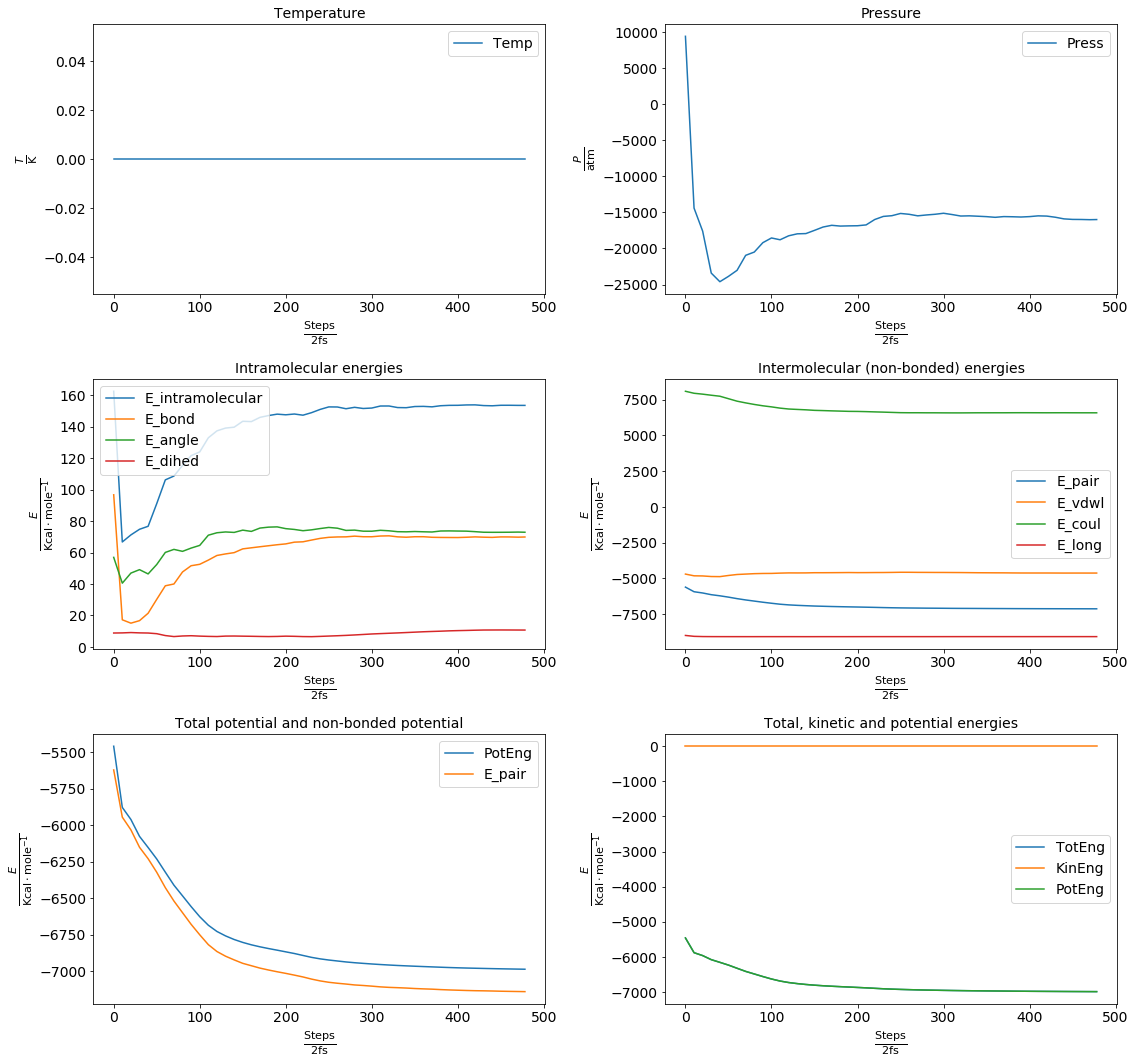

In [34]:
makeThermoPlotsFromDataFrame(minimization_thermo_pd);

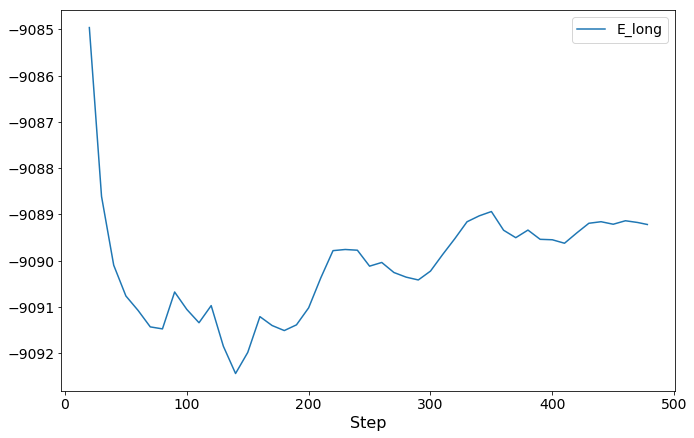

In [35]:
minimization_thermo_pd[["E_long"]][2:].plot()

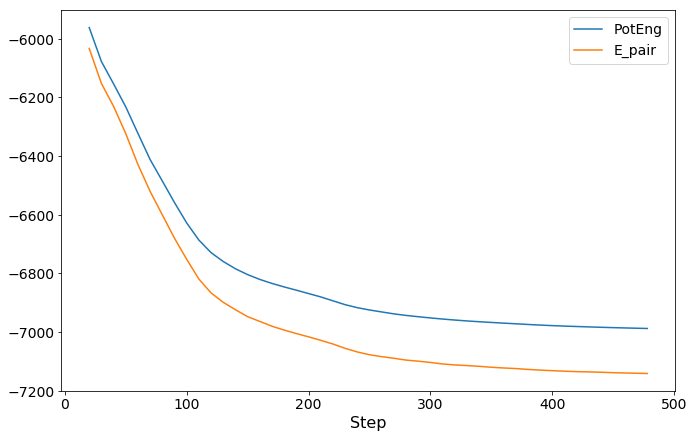

In [36]:
# The total energy decreases, but intramolecular energy increases during minimization:
minimization_thermo_pd[["PotEng","E_pair"]][2:].plot()

In [37]:
# double-check: total potential energy of system minus non-bonded energy (LJ & Coulomb) 
# should correspond to intramolecular energy:
intramolecularEnergyValidation = minimization_thermo_pd["PotEng"] - minimization_thermo_pd["E_pair"]

In [38]:
intramolecularEnergyValidationDiff = (intramolecularEnergyValidation - minimization_thermo_pd["E_intramolecular"])

In [39]:
intramolecularEnergyValidationDiff.max()

7.7900000391650792e-05

In [40]:
intramolecularEnergyValidationDiff.abs().max() / intramolecularEnergyValidation.min()

1.3483832875877057e-06

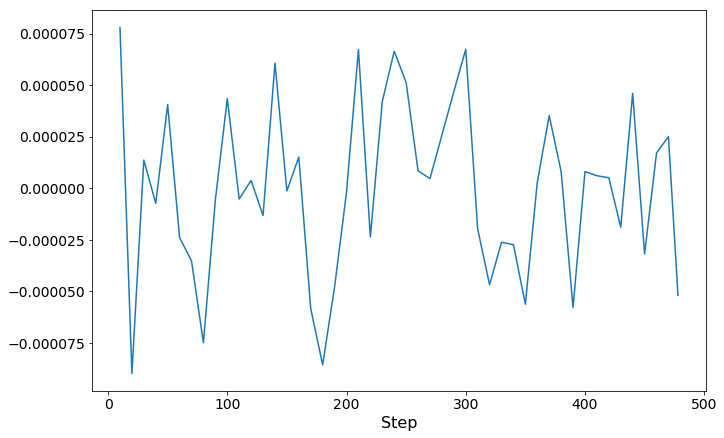

In [41]:
(intramolecularEnergyValidation - minimization_thermo_pd["E_intramolecular"])[1:].plot()
# obviously "equal" (up to a tiny fraction)

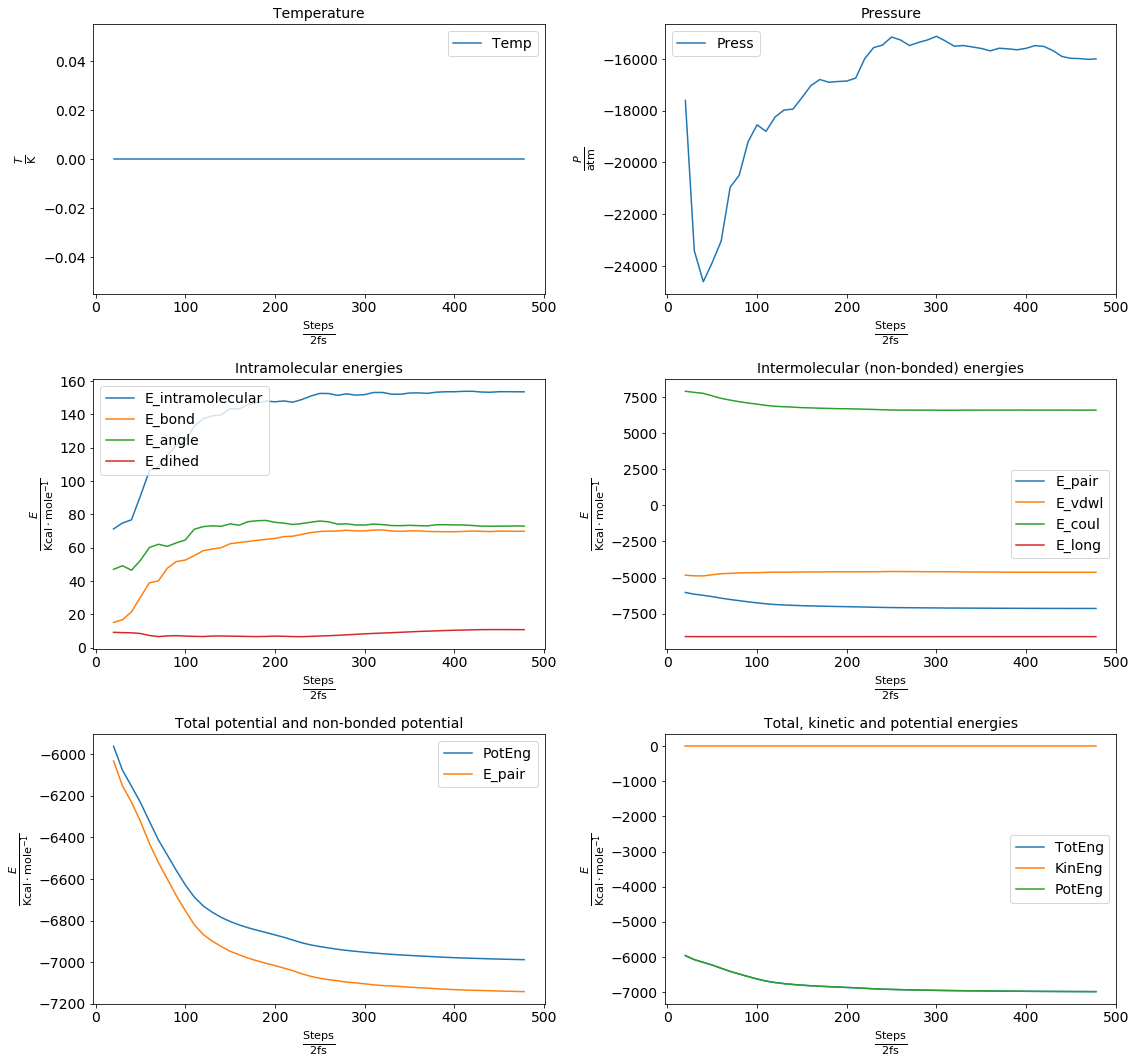

In [42]:
# descent to steep t the first few steps, excluded
makeThermoPlotsFromDataFrame(minimization_thermo_pd.iloc[2:].copy());

### 2.2. NVT equilibration

In [43]:
%ls *nvtEquilibration.log

1_SDS_on_AU_111_6x4x1_02_nvtEquilibration.log


In [44]:
!./extract_thermo.sh *nvtEquilibration.log 02_nvtEquilibration_thermo.out

In [45]:
nvtEquilibration_thermo_file = absolute_prefix + os.sep + '02_nvtEquilibration_thermo.out'

In [46]:
nvtEquilibration_thermo_pd = pd.read_csv(nvtEquilibration_thermo_file,delim_whitespace=True)

In [47]:
nvtEquilibration_thermo_pd.set_index("Step",inplace=True)

In [48]:
nvtEquilibration_thermo_pd

TotEng     KinEng     PotEng       Temp       Press   Enthalpy  \
Step                                                                      
0    -6763.7844  348.10825 -7111.8926  231.86586 -14314.3510 -8766.5684   
10   -6513.9781  222.99656 -6736.9746  148.53221 -10706.5170 -8011.9742   
20   -6502.7291  201.46526 -6704.1944  134.19077  -9997.2945 -7901.4948   
30   -6484.3409  185.89250 -6670.2334  123.81816  -9620.7307 -7830.4199   
40   -6458.0414  186.68442 -6644.7258  124.34564  -9241.8798 -7751.1136   
50   -6420.4803  219.48482 -6639.9651  146.19314 -10771.5180 -7927.5710   
60   -6365.5898  258.91304 -6624.5029  172.45524 -10808.7900 -7877.8954   
70   -6290.2909  313.80781 -6604.0987  209.01923 -11538.5120 -7904.6950   
80   -6194.6453  364.81130 -6559.4566  242.99133 -11218.3960 -7764.2607   
90   -6076.1562  417.23663 -6493.3928  277.91047 -11390.7680 -7669.8889   
100  -5929.7567  517.77278 -6447.5294  344.87499 -11659.1350 -7561.0377   
110  -5763.6337  607.07205 -6370.7057  404.35491 -10887.6700 -7286.9757   
120  -5588.6534  678.91155 -6267.5649  452.20534  -9810.5791 -6961.2949   
130  -5428.2394  755.23098 -6183.4703  503.03973  -9082.1616 -6698.9647   
140  -5294.9221  803.55101 -6098.4731  535.22445  -7283.0482 -6313.9255   
150  -5206.9405  832.78531 -6039.7258  554.69665  -7928.9294 -6316.3120   
160  -5173.2989  825.64769 -5998.9466  549.94247  -8695.8552 -6389.9744   
170  -5196.8124  813.47664 -6010.2890  541.83565  -8983.0998 -6453.6776   
180  -5265.6400  710.32365 -5975.9636  473.12812 -10102.9160 -6679.1836   
190  -5361.4647  648.81256 -6010.2773  432.15719 -10599.8910 -6844.5423   
200  -5467.3303  572.03864 -6039.3689  381.02007 -11454.5070 -7069.9810   
210  -5571.4335  485.59764 -6057.0311  323.44397 -13513.3020 -7462.1392   
220  -5667.7138  444.55219 -6112.2660  296.10466 -14022.4960 -7629.6631   
230  -5755.9889  413.41450 -6169.4034  275.36465 -14784.2330 -7824.5162   
240  -5834.6406  377.36789 -6212.0085  251.35494 -15370.2530 -7985.1606   
250  -5903.0172  357.85430 -6260.8715  238.35745 -14815.0130 -7975.8511   
260  -5961.7592  344.78146 -6306.5406  229.64997 -16353.5750 -8249.8601   
270  -6014.0057  337.83625 -6351.8420  225.02395 -15722.3440 -8213.7884   
280  -6057.4932  320.52141 -6378.0147  213.49098 -15747.4790 -8260.7927   
290  -6092.4630  319.65837 -6412.1214  212.91613 -16274.4860 -8369.4983   
...         ...        ...        ...        ...         ...        ...   
2210 -6007.7597  419.66177 -6427.4215  279.52580 -13989.0390 -7965.0279   
2220 -6002.3283  430.83641 -6433.1647  286.96894 -14055.9340 -7968.9561   
2230 -5995.8366  442.00724 -6437.8439  294.40954 -13899.7330 -7940.6098   
2240 -5989.3043  440.67392 -6429.9782  293.52144 -13501.4370 -7878.3500   
2250 -5982.0874  431.78922 -6413.8766  287.60358 -12505.2450 -7731.7516   
2260 -5974.7964  442.68772 -6417.4841  294.86279 -11337.5200 -7561.0789   
2270 -5966.3492  461.77653 -6428.1257  307.57734 -12123.0850 -7662.5436   
2280 -5958.8658  458.89031 -6417.7561  305.65491 -11583.2030 -7579.5229   
2290 -5952.4653  467.34569 -6419.8110  311.28682 -11582.4220 -7573.0131   
2300 -5947.1583  474.78460 -6421.9429  316.24168 -11712.7630 -7585.9427   
2310 -5943.9223  487.09813 -6431.0204  324.44341 -11888.3200 -7607.2696   
2320 -5944.3020  482.17505 -6426.4770  321.16427 -11007.1360 -7484.3590   
2330 -5946.9971  458.33493 -6405.3320  305.28499 -10512.6510 -7417.8686   
2340 -5951.0540  474.92118 -6425.9752  316.33266  -9443.4421 -7272.3277   
2350 -5956.0780  450.01977 -6406.0977  299.74647  -9374.0966 -7267.6493   
2360 -5961.5178  440.82968 -6402.3475  293.62519  -9335.0877 -7267.6312   
2370 -5966.2848  447.02517 -6413.3099  297.75185  -9176.0078 -7250.1406   
2380 -5970.6661  449.03629 -6419.7024  299.09140 -10711.5360 -7469.3644   
2390 -5974.0385  424.13951 -6398.1780  282.50831  -9610.2610 -7318.6526   
2400 -5976.5571  450.71089 -6427.2680  300.20681 -10693.3310 -7472.7084   
2410 -5979.7096  463.51096 -6443.2

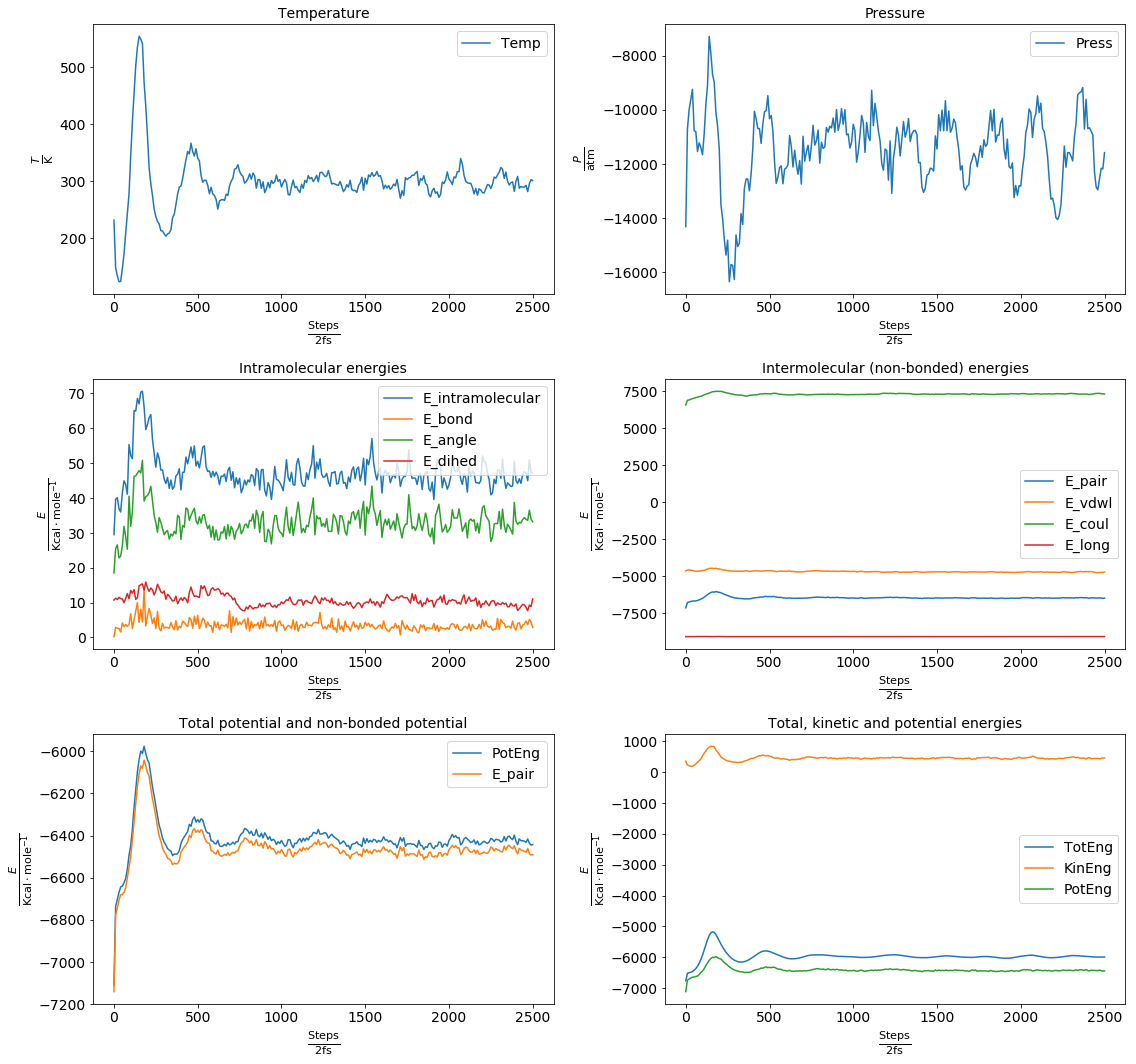

In [49]:
makeThermoPlotsFromDataFrame(nvtEquilibration_thermo_pd);

### 2.3. NPT equilibration

In [50]:
%ls *nptEquilibration.log

1_SDS_on_AU_111_6x4x1_03_nptEquilibration.log


In [51]:
!./extract_thermo.sh *nptEquilibration.log 03_nptEquilibration_thermo.out

In [52]:
nptEquilibration_thermo_file = absolute_prefix + os.sep + '03_nptEquilibration_thermo.out'

In [53]:
nptEquilibration_thermo_pd = pd.read_csv(nptEquilibration_thermo_file,delim_whitespace=True)

In [54]:
nptEquilibration_thermo_pd.set_index("Step",inplace=True)

In [55]:
nptEquilibration_thermo_pd

TotEng     KinEng     PotEng       Temp         Press   Enthalpy  \
Step                                                                        
2500 -5990.5852  452.38582 -6442.9711  301.32244 -11581.378000 -7610.9870   
2510 -6015.0921  488.90544 -6503.9975  325.64720   5610.763000 -5273.6183   
2520 -6012.7616  492.45523 -6505.2169  328.01163   -375.508450 -6063.0711   
2530 -6024.2903  514.06653 -6538.3568  342.40636   -572.210290 -6100.2684   
2540 -6038.3161  492.74193 -6531.0580  328.20259   -570.471850 -6113.8022   
2550 -6055.2947  482.58808 -6537.8828  321.43938    340.699460 -6010.5394   
2560 -6073.3745  478.41611 -6551.7906  318.66054   -545.971190 -6144.5442   
2570 -6098.2152  483.08915 -6581.3043  321.77313   -780.709290 -6199.3166   
2580 -6123.6492  488.76667 -6612.4158  325.55477    309.134220 -6084.0922   
2590 -6154.0525  473.90573 -6627.9582  315.65629    -58.510564 -6161.5034   
2600 -6184.6380  451.58766 -6636.2257  300.79080   -797.708250 -6285.8552   
2610 -6216.0617  440.45556 -6656.5173  293.37600    334.255090 -6173.9087   
2620 -6241.6391  417.04220 -6658.6813  277.78097    -20.979210 -6244.2668   
2630 -6269.9187  407.84355 -6677.7623  271.65399   -877.386700 -6379.8406   
2640 -6289.8804  383.15066 -6673.0310  255.20670   1434.447400 -6111.9693   
2650 -6306.1670  379.51129 -6685.6783  252.78261  -1369.465900 -6476.7201   
2660 -6321.2798  385.08462 -6706.3644  256.49486    643.861850 -6241.5589   
2670 -6325.6576  381.07671 -6706.7343  253.82530     34.461799 -6321.3928   
2680 -6331.1508  393.30284 -6724.4536  261.96880   -841.404470 -6435.5765   
2690 -6329.3779  414.77341 -6744.1513  276.26979    760.909350 -6235.3149   
2700 -6326.1967  415.56184 -6741.7586  276.79494    757.683120 -6232.2290   
2710 -6320.2689  407.50664 -6727.7755  271.42958   -538.888710 -6387.5741   
2720 -6313.4434  381.23236 -6694.6758  253.92897    395.853760 -6263.9485   
2730 -6299.6797  391.13707 -6690.8168  260.52624   -370.644140 -6346.1575   
2740 -6285.1224  405.74936 -6690.8718  270.25911   -136.962050 -6302.2990   
2750 -6262.5014  442.42467 -6704.9261  294.68757    337.690980 -6220.2391   
2760 -6241.6709  450.23267 -6691.9035  299.88828   -472.895230 -6301.1477   
2770 -6218.4368  451.50497 -6669.9418  300.73573   1032.125800 -6088.7055   
2780 -6195.4682  450.34666 -6645.8149  299.96420   -801.749190 -6296.9259   
2790 -6174.9821  453.92219 -6628.9043  302.34577    725.225240 -6083.3628   
...         ...        ...        ...        ...           ...        ...   
4710 -6224.9582  458.01941 -6682.9776  305.07483    218.861860 -6199.1306   
4720 -6217.8703  487.25696 -6705.1273  324.54920    803.537650 -6123.0974   
4730 -6214.1085  470.01515 -6684.1237  313.06487    -73.115308 -6222.7308   
4740 -6216.9594  475.61124 -6692.5706  316.79229  -1516.114800 -6396.3243   
4750 -6216.5011  492.71424 -6709.2154  328.18415   2150.130900 -5965.2044   
4760 -6221.5261  469.73601 -6691.2621  312.87895  -1408.527600 -6387.3771   
4770 -6232.9861  454.43124 -6687.4173  302.68484    -92.524104 -6243.8253   
4780 -6236.7948  444.40734 -6681.2021  296.00818    751.653980 -6148.7766   
4790 -6246.6111  439.14023 -6685.7513  292.49989  -1130.724900 -6379.5256   
4800 -6251.0123  457.96688 -6708.9792  305.03984   1424.214900 -6085.4854   
4810 -6261.0881  468.43226 -6729.5204  312.01055  -1333.037900 -6416.9190   
4820 -6268.6801  459.88052 -6728.5606  306.31446   1799.723300 -6060.9298   
4830 -6280.3794  458.50237 -6738.8817  305.39651  -2428.971500 -6563.8920   
4840 -6294.0926  449.41613 -6743.5088  299.34440   1671.756700 -6101.2305   
4850 -6297.9210  429.78214 -6727.7031  286.26671    730.662840 -6213.2540   
4860 -6310.6064  399.75521 -6710.3616  266.26656  -2844.889100 -6642.3493   
4870 -6314.8137  423.17611 -6737.9898  281.86661   3089.782200 -5959.7189   
4880 -6312.6482  429.72700 -6742.3752  286.22999   -377.936880 -6356.2860   
4890 -6323.7669  414.89814 -6738.6651  276.35287  -2574.376000 -6622.0883   
4900 

In [56]:
equilibration_pd = pd.concat([nvtEquilibration_thermo_pd,nptEquilibration_thermo_pd])

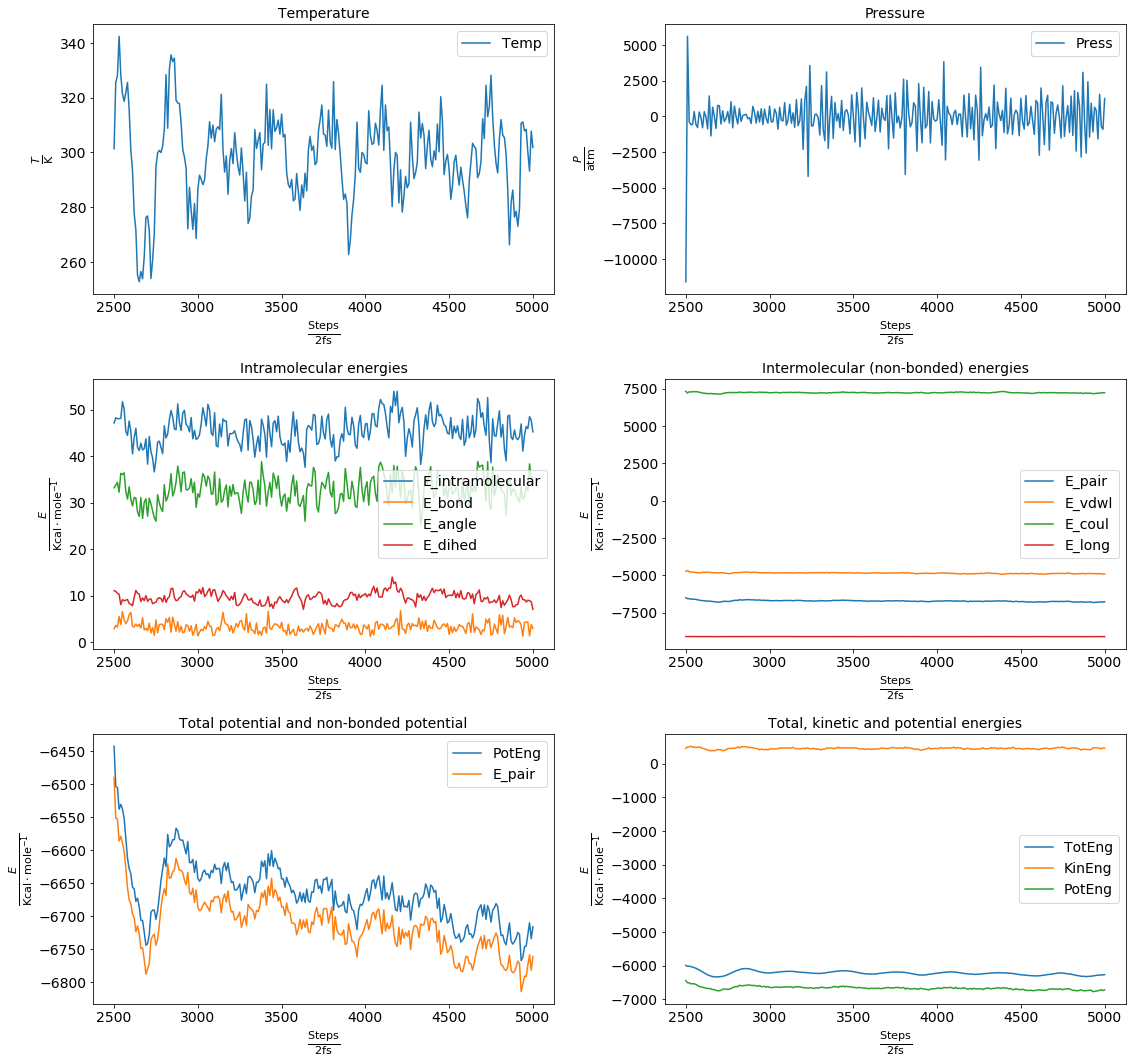

In [57]:
makeThermoPlotsFromDataFrame(nptEquilibration_thermo_pd);

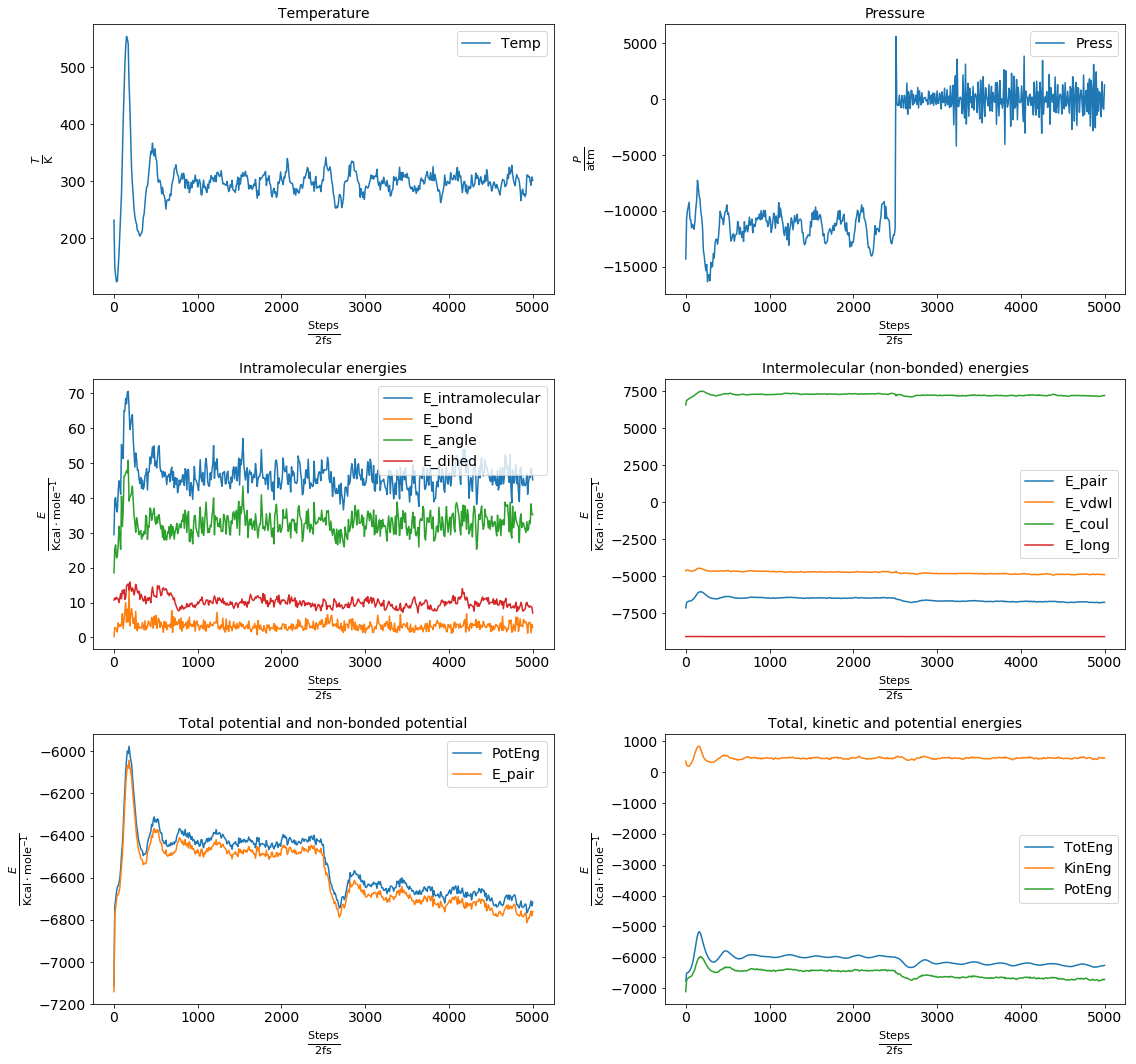

In [58]:
# show nvt and npt equilibration consecutively
makeThermoPlotsFromDataFrame(equilibration_pd);

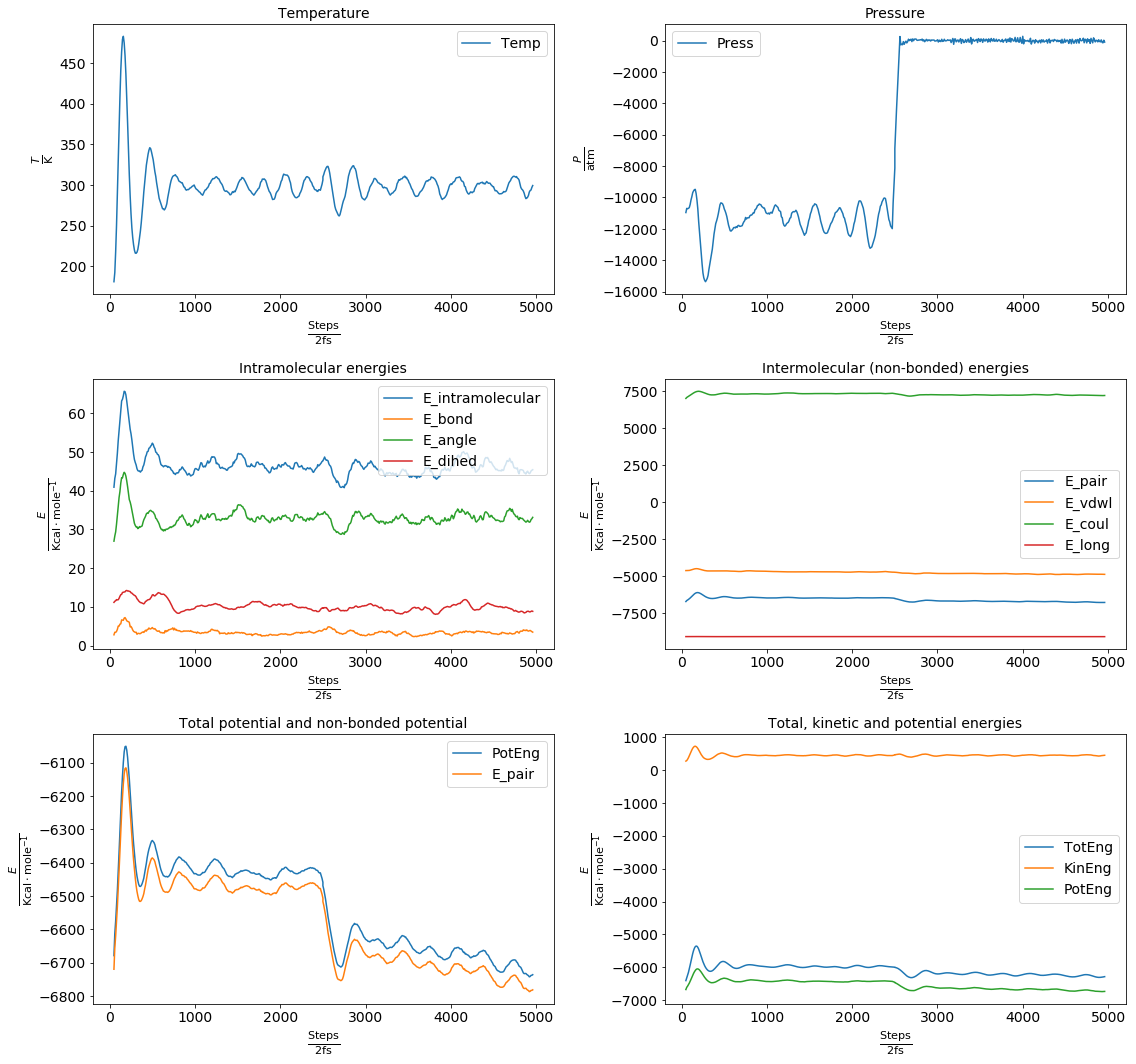

In [59]:
makeRollingAverageThermoPlotsFromDataFrame(equilibration_pd,window=10);

### 2.4. 10 ps NPT

In [ ]:
!./extract_thermo.sh *_10ps_npt_01_nptProduction.log 05_10ps_nptProduction_thermo.out

In [ ]:
nptProduction10ps_thermo_file = absolute_prefix + os.sep + '05_10ps_nptProduction_thermo.out'

In [ ]:
nptProduction10ps_thermo_pd = pd.read_csv(nptProduction10ps_thermo_file,delim_whitespace=True)

In [ ]:
nptProduction10ps_thermo_pd.set_index("Step",inplace=True)

In [ ]:
nptProduction10ps_thermo_pd

In [ ]:
makeThermoPlotsFromDataFrame(nptProduction10ps_thermo_pd);

In [ ]:
makeRollingAverageThermoPlotsFromDataFrame(nptProduction10ps_thermo_pd,window=10);

### 2.5. 100 ps NPT

In [ ]:
!./extract_thermo.sh *_100ps_npt_01_nptProduction.log 05_100ps_nptProduction_thermo.out

In [ ]:
nptProduction_100ps_thermo_file = absolute_prefix + os.sep + '05_100ps_nptProduction_thermo.out'
nptProduction_100ps_thermo_pd = pd.read_csv(nptProduction_100ps_thermo_file,delim_whitespace=True)
nptProduction_100ps_thermo_pd.set_index("Step",inplace=True)

In [ ]:
makeThermoPlotsFromDataFrame(nptProduction_100ps_thermo_pd.iloc[::20].copy()); # only every 20th data point

### 2.6. 1 ns NPT

In [60]:
%ls *_1ns_npt_with_restarts_01_nptProduction.log

1_SDS_on_AU_111_6x4x1_1ns_npt_with_restarts_01_nptProduction.log


In [61]:
!./extract_thermo.sh *_1ns_npt_with_restarts_01_nptProduction.log 05_1ns_nptProduction_thermo.out

In [62]:
nptProduction_1ns_thermo_file = absolute_prefix + os.sep + '05_1ns_nptProduction_thermo.out'
nptProduction_1ns_thermo_pd = pd.read_csv(nptProduction_1ns_thermo_file,delim_whitespace=True)
nptProduction_1ns_thermo_pd.set_index("Step",inplace=True)

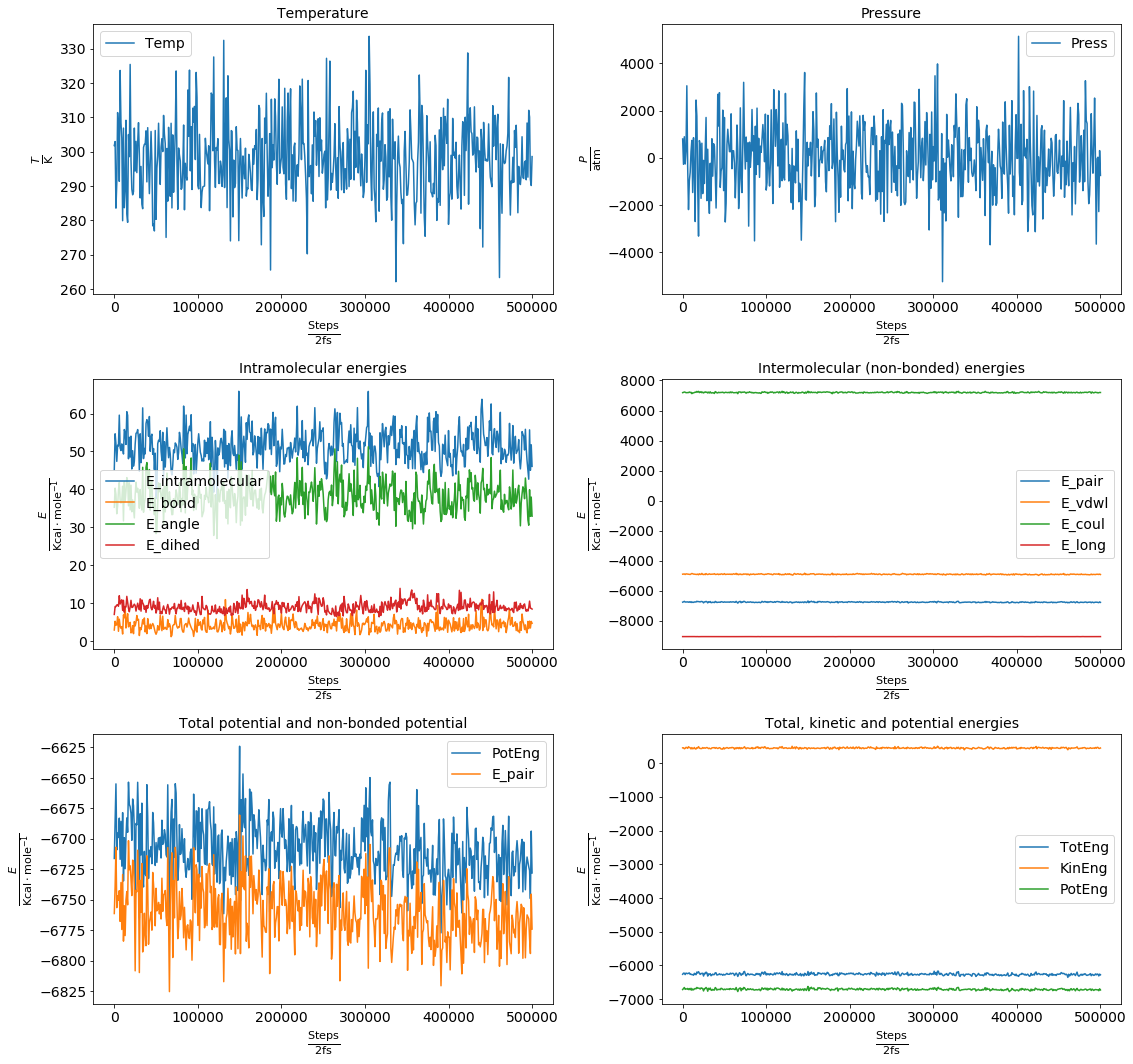

In [63]:
makeThermoPlotsFromDataFrame(nptProduction_1ns_thermo_pd.iloc[::100].copy()); # only every 100th data point

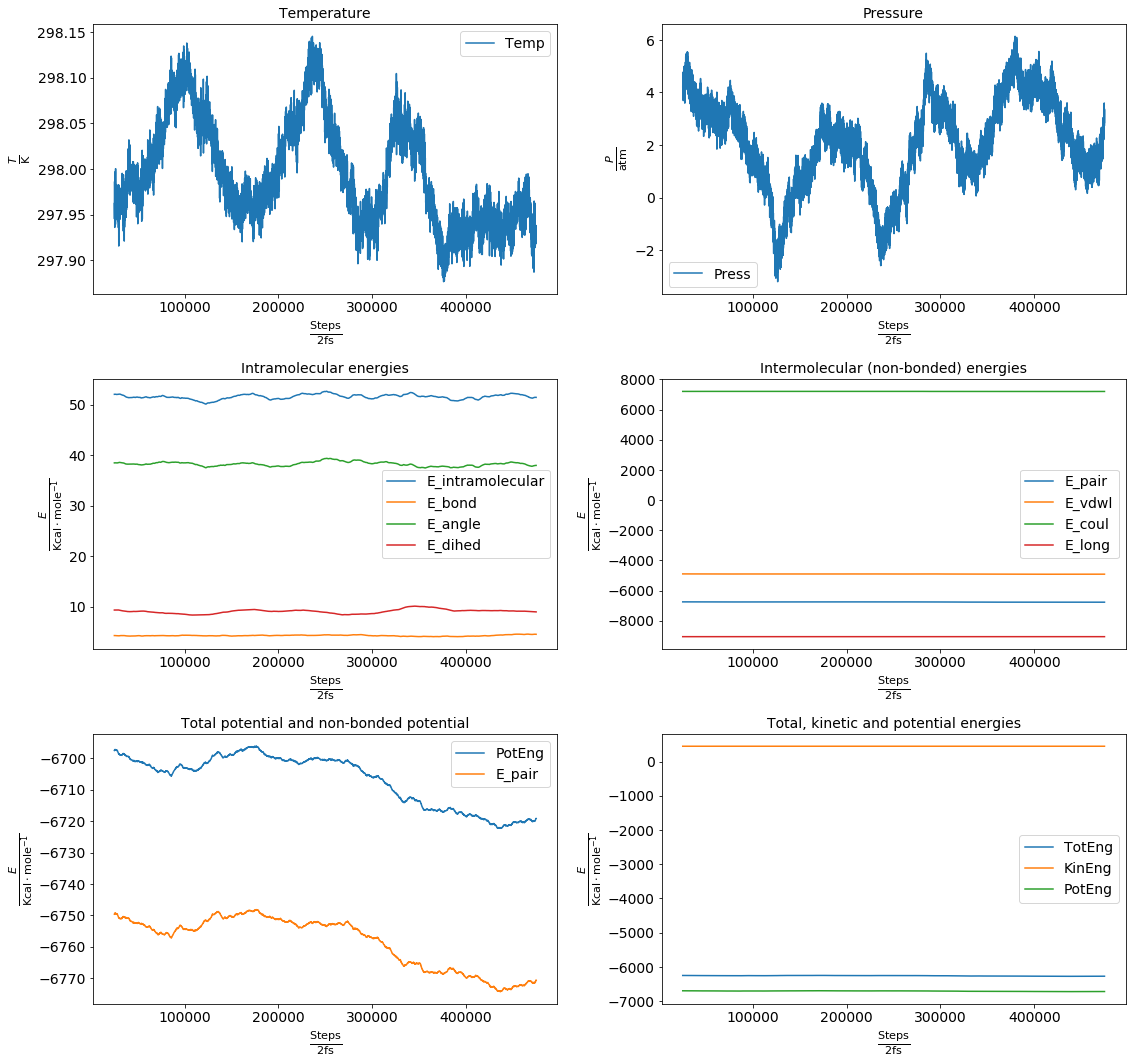

In [64]:
makeRollingAverageThermoPlotsFromDataFrame(nptProduction_1ns_thermo_pd,window=5000);

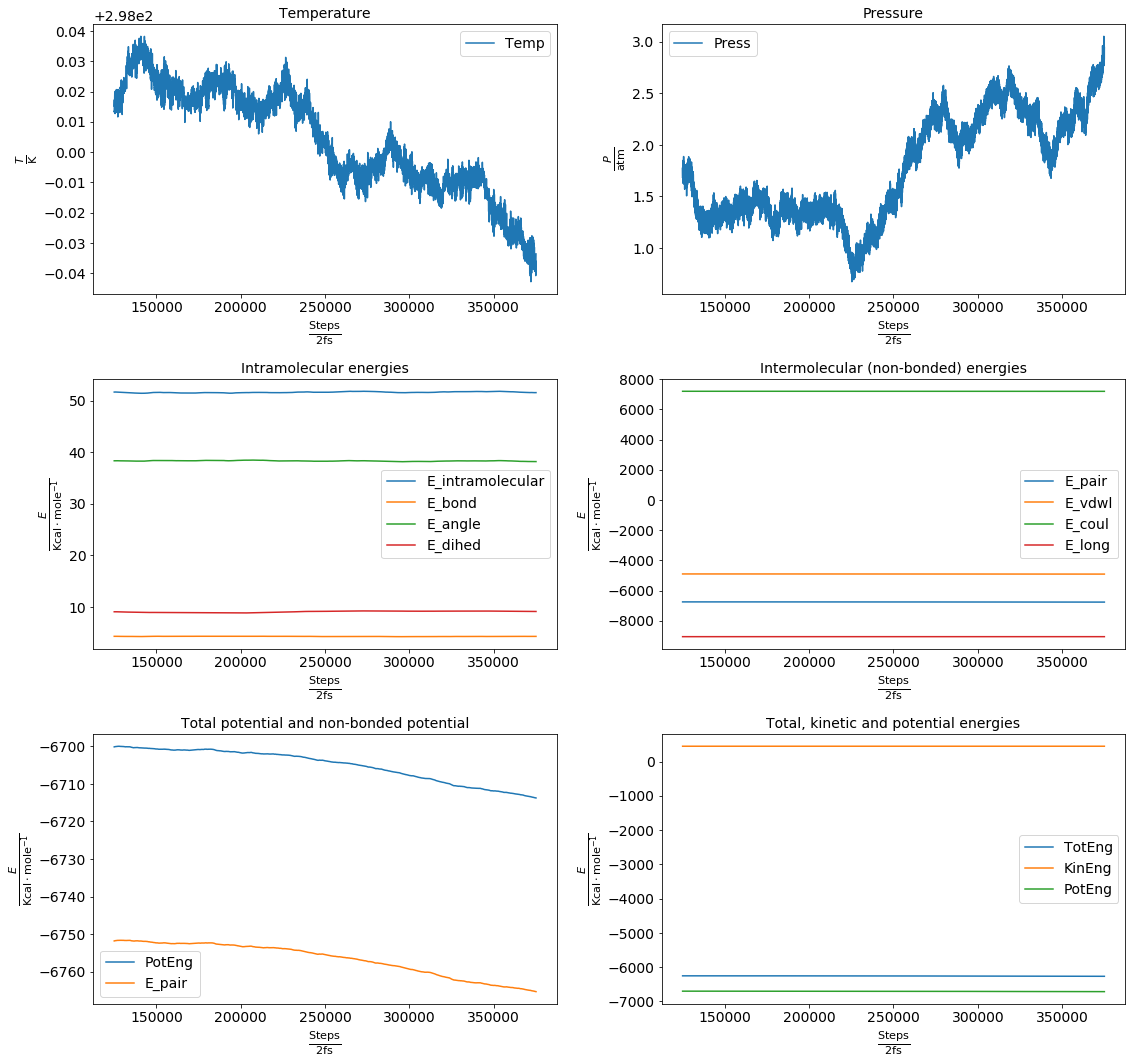

In [65]:
makeRollingAverageThermoPlotsFromDataFrame(nptProduction_1ns_thermo_pd,window=25000);

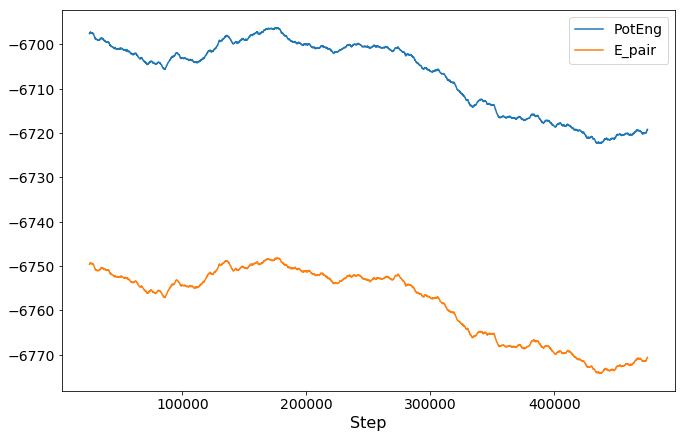

In [66]:
nptProduction_1ns_thermo_pd[["PotEng","E_pair"]].rolling(window=5000,center=True).mean().plot()

### 2.7. 1 ns NVE

In [68]:
%ls *_1ns_nve_with_restarts_01_nveProduction.log

1_SDS_on_AU_111_6x4x1_1ns_nve_with_restarts_01_nveProduction.log


In [69]:
!./extract_thermo.sh *_1ns_nve_with_restarts_01_nveProduction.log 05_1ns_nveProduction_thermo.out

In [71]:
nveProduction_1ns_thermo_file = absolute_prefix + os.sep + '05_1ns_nveProduction_thermo.out'
nveProduction_1ns_thermo_pd = pd.read_csv(nveProduction_1ns_thermo_file,delim_whitespace=True)
nveProduction_1ns_thermo_pd.set_index("Step",inplace=True)

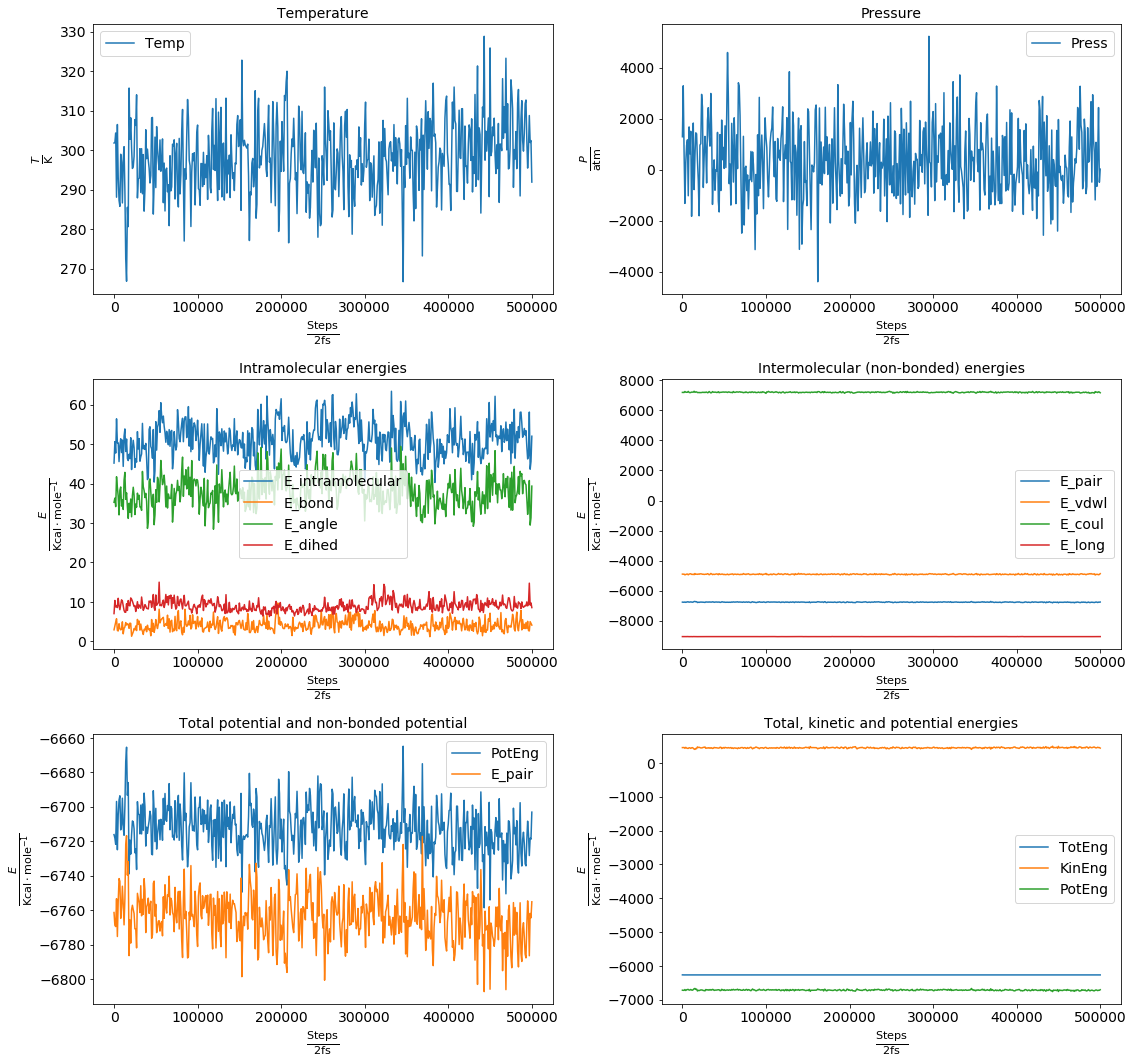

In [72]:
makeThermoPlotsFromDataFrame(nveProduction_1ns_thermo_pd.iloc[::100].copy()); # only every 100th data point

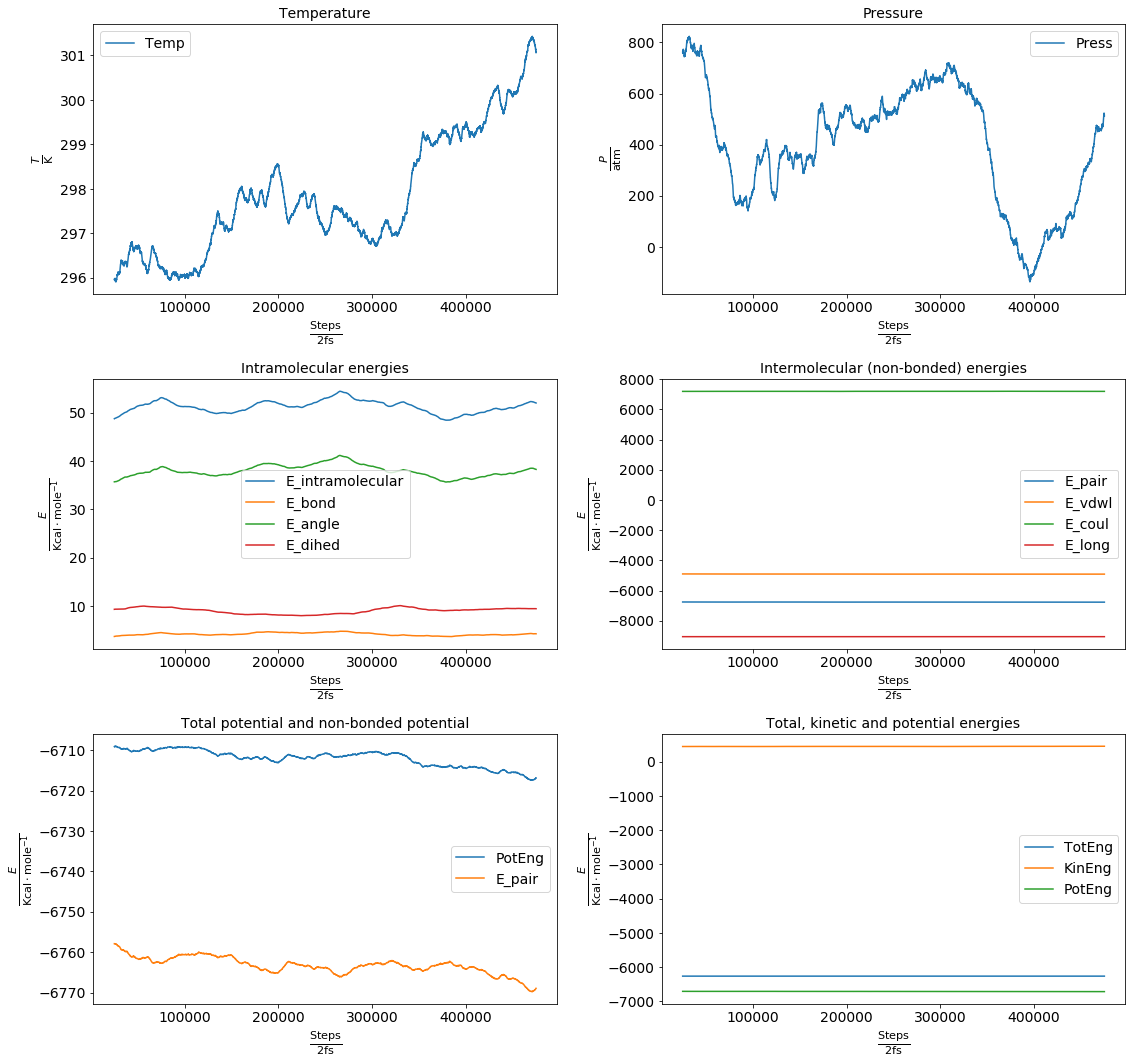

In [73]:
makeRollingAverageThermoPlotsFromDataFrame(nveProduction_1ns_thermo_pd,window=5000);

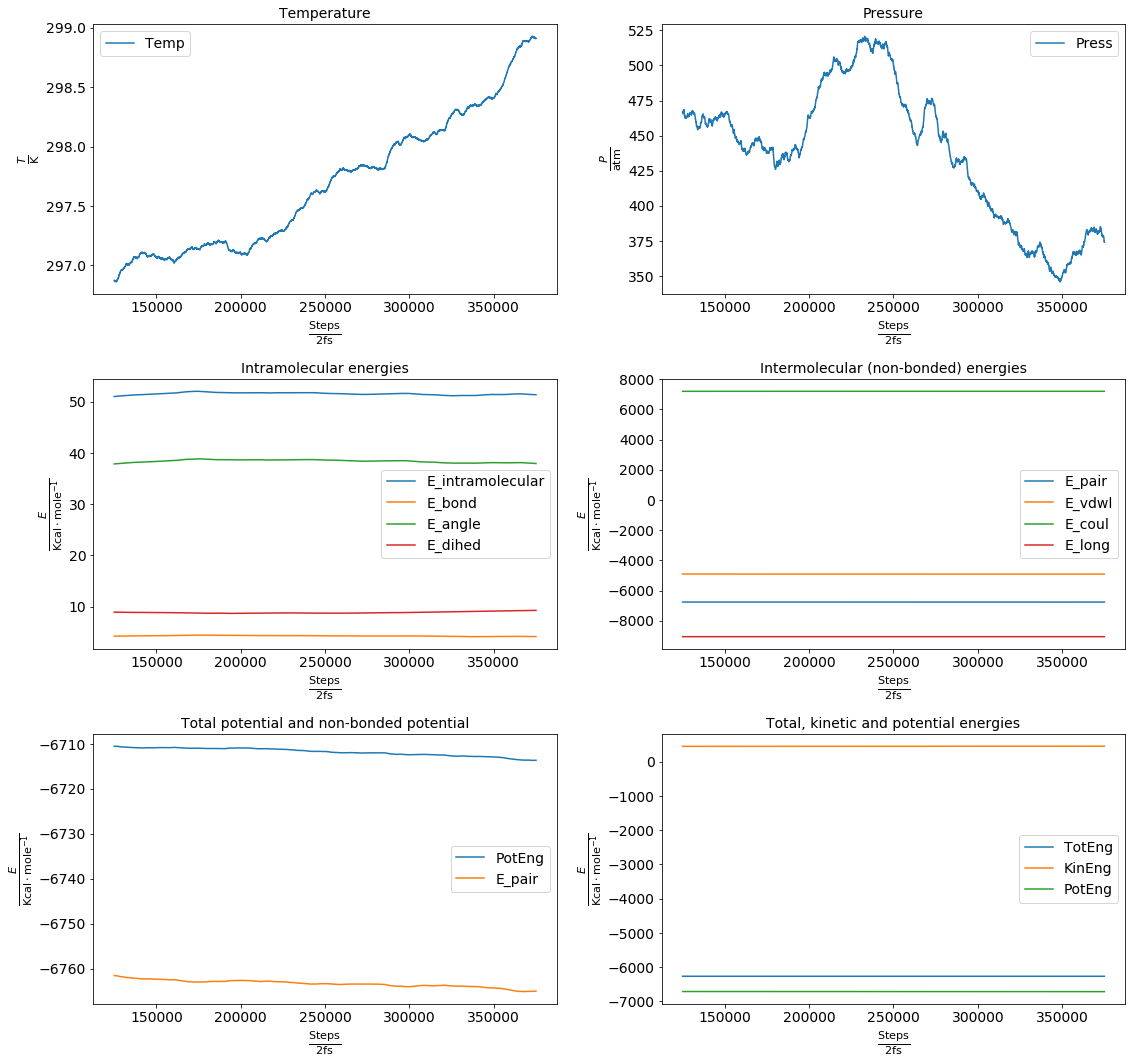

In [74]:
makeRollingAverageThermoPlotsFromDataFrame(nveProduction_1ns_thermo_pd,window=25000);

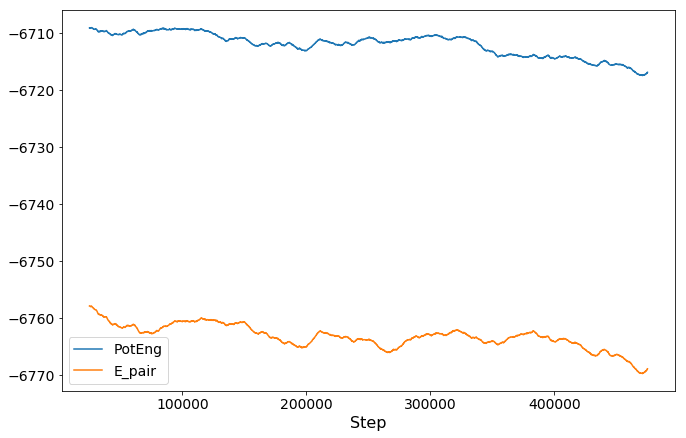

In [75]:
nveProduction_1ns_thermo_pd[["PotEng","E_pair"]].rolling(window=5000,center=True).mean().plot()

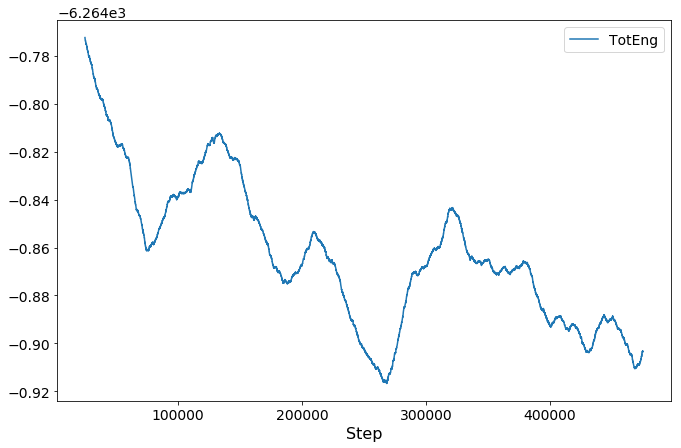

In [324]:
nveProduction_1ns_thermo_pd[["TotEng"]].rolling(window=5000,center=True).mean().plot()

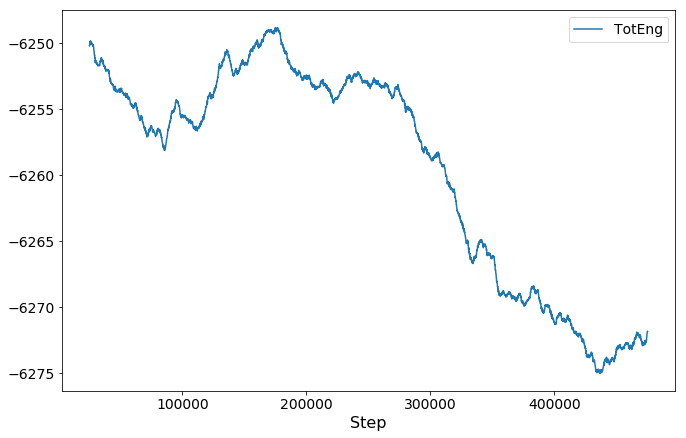

In [323]:
nptProduction_1ns_thermo_pd[["TotEng"]].rolling(window=5000,center=True).mean().plot()

## 3. Trajectory visualization with ASE and ParmEd

In [76]:
%ls *.lammps

1_SDS_on_AU_111_6x4x1_1ns_npt_with_restarts_final_config.lammps
1_SDS_on_AU_111_6x4x1_1ns_nve_with_restarts_final_config.lammps
1_SDS_on_AU_111_6x4x1_minimized.lammps
1_SDS_on_AU_111_6x4x1_nptEquilibrated.lammps
1_SDS_on_AU_111_6x4x1_nvtEquilibrated.lammps
log.lammps


In [77]:
%ls *.dump

1_SDS_on_AU_111_6x4x1_1ns_npt_with_restarts_nptProduction.dump
1_SDS_on_AU_111_6x4x1_1ns_nve_with_restarts_nveProduction.dump
1_SDS_on_AU_111_6x4x1_nptEquilibration.dump
1_SDS_on_AU_111_6x4x1_nvtEquilibration.dump


In [94]:
# File names
prefix = '1_SDS_on_AU_111_6x4x1_'

pdb_file_initial_config = absolute_prefix + os.sep + prefix + 'psfgen_ctrl.pdb'

lmp_files = { 'initial':         prefix + 'psfgen.data',
              'minimized':       prefix + 'minimized.lammps',
              'nvtEquilibrated': prefix + 'nvtEquilibrated.lammps',
              'nptEquilibrated': prefix + 'nptEquilibrated.lammps',
              #'npt10ps':         prefix + '10ps_npt_final_config.lammps',
              #'npt100ps':        prefix + '100ps_npt_final_config.lammps',
              'npt1ns':          prefix + '1ns_npt_with_restarts_final_config.lammps',
              'nve1ns':          prefix + '1ns_nve_with_restarts_final_config.lammps'}

lmp_dumps = { 
              'nvtEquilibration': prefix + 'nvtEquilibration.dump',
              'nptEquilibration': prefix + 'nptEquilibration.dump',
              #'npt10ps':          prefix + '10ps_npt_nptProduction.dump',
              #'npt100ps':         prefix + '100ps_npt_nptProduction.dump',
              'npt1ns':           prefix + '1ns_npt_with_restarts_nptProduction.dump',
              'nve1ns':           prefix + '1ns_nve_with_restarts_nveProduction.dump' }

In [79]:
# construct a dictionary-like atom type-> atom number array
t2n, t2n_array = inferTypes2NumbersFromPdbAndLmp(pdb_file_initial_config, lmp_files['initial'])

PDB contains following residue types ['AUM' 'HOH' 'ION' 'SDS']
System contains 11 atom types.


In [80]:
t2n

{1: 1, 2: 1, 3: 6, 4: 6, 5: 8, 6: 8, 7: 16, 8: 79, 9: 1, 10: 8, 12: 11}

In [81]:
t2n_array

array([ 0,  1,  1, ...,  8,  0, 11], dtype=uint64)

### 3.1. Initial configuration from .pdb

In [82]:
# create atom selections for later post-processing:
struct_pdb_pmd     = pmd.read_PDB(pdb_file_initial_config)
water              = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'HOH' ] # water
water_indices      = [ a.number - 1 for a in water ] # to remove water atoms later
surface            = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'AUM' ] # gold surface
surface_indices    = [ a.number - 1 for a in surface ] 
surfactant         = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'SDS' ]
surfactant_indices = [ a.number - 1 for a in surfactant ] 
ions               = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'ION' ] # sodium counterions
ion_indices        = [ a.number - 1 for a in ions ] 

In [83]:
surface_indices[0] # double check index begins at 0

0

In [84]:
len(surfactant_indices)

42

In [85]:
ions

[<Atom SOD [537]; In ION 262>]

In [86]:
ions[0].atomic_number # wrong: inferred S (sulfur)

16

In [87]:
nv.show_parmed(struct_pdb_pmd)

NGLWidget()

### 3.2. LAMMPS data files

In [88]:
# read frames of interest
lmp_frames = {}
for k,f in lmp_files.items():
    lmp_frames[k] = read(lmp_files[k],format='lammps-data')
    lmp_frames[k].set_atomic_numbers(
        t2n_array[lmp_frames[k].get_atomic_numbers() ] )

In [89]:
lmp_frames['minimized']

Atoms(symbols='C12H351Au144NaO167S', pbc=True, cell=[19.7253864, 19.7253864, 24.656734], angles=..., bonds=..., id=..., masses=..., mol-id=..., momenta=..., travel=..., type=...)

In [90]:
lmp_views = []
for k, f in lmp_frames.items():
    lmp_views.append( nv.show_ase(f) )
    lmp_views[-1]._set_sync_camera()
    lmp_views[-1]._remote_call("setSize", target="Widget", args=["250px", "250px"])
    lmp_views[-1].center()
    lmp_views[-1].render_image()

In [91]:
vbox = ipywidgets.VBox(lmp_views)

In [92]:
vbox

VBox(children=(NGLWidget(), NGLWidget(), NGLWidget(), NGLWidget(), NGLWidget(), NGLWidget()))

### 3.3. LAMMPS trajectories

In [95]:
lmp_trajectrories = {}
for k,t in lmp_dumps.items():
    lmp_trajectrories[k] = read(t, index=':',format='lammps-dump')
    for f in lmp_trajectrories[k]:      
        f.set_atomic_numbers(
            t2n_array[f.get_atomic_numbers() ] )
        f.center()

In [96]:
%memit

peak memory: 720.64 MiB, increment: -4.31 MiB


In [97]:
len(lmp_trajectrories['nvtEquilibration'])

26

In [98]:
view(lmp_trajectrories['npt1ns'], viewer='ase') # opens ASE GUI

In [99]:
#nv.show_asetraj(lmp_trajectrories['npt100ps'])

In [100]:
# Several problems with nglview:
#  1) does not display or infer bonding for ASE trajectory
#  2) even with displayed gui, not clear how to activate

### 3.4. LAMMPS trajectories, stripped of solvent

In [294]:
lmp_naked_trajectrories = {}
for k in lmp_trajectrories:
    lmp_naked_trajectrories[k] = []
    for f in lmp_trajectrories[k]:
        g = f.copy()
        del g[water_indices]
        lmp_naked_trajectrories[k].append(g)

In [102]:
trajectoryView = nv.show_asetraj(lmp_naked_trajectrories['npt1ns'][::100])

In [103]:
trajectoryView.remove_ball_and_stick()

In [104]:
trajectoryView.add_spacefill() # try a different representation sytle

In [105]:
trajectoryView

NGLWidget(count=51)

In [106]:
view(lmp_naked_trajectrories['npt1ns'], viewer='ase') # opens ASE GUI

In [107]:
# Several problems with nglview:
#  1) does not display or infer bonding for ASE trajectory
#  2) even with displayed gui, not clear how to activate

### 3.5. Make a movie via .png frames and ffmpeg

In [108]:
# create a subdir from within the notebook
%mkdir png

In [298]:
traj = lmp_naked_trajectrories['npt1ns']

In [243]:
nv.show_ase(traj[200])

NGLWidget()

In [113]:
# from ~ frame 3500 to the end ~ means

In [114]:
totalFramesAvailable = 5000

In [115]:
desiredVideoDuration = 30 # s

In [116]:
framesPerSecond = 30 # s^-1

In [117]:
neededFrames = desiredVideoDuration*framesPerSecond

In [118]:
neededFrames

900

In [119]:
every_nth = np.ceil(totalFramesAvailable / neededFrames).astype(int)

In [120]:
every_nth

6

In [121]:
png_prefix = absolute_prefix + os.sep + 'png' + os.sep + 'traj_1ns'

In [313]:
f = traj[0].copy()

In [314]:
# find a desired orientation
#f.rotate('x', (-1,2,-1), rotate_cell=True)
f.rotate('-y', 'z', rotate_cell=True)

In [315]:
nv.show_ase(f)

NGLWidget()

In [316]:
cell = f.get_cell()

In [317]:
cell

array([[ 18.48465488,   0.        ,   0.        ],
       [  0.        ,   0.        , -18.48465488],
       [  0.        ,  23.10581954,   0.        ]])

In [319]:
bbox = [-5, -5, 24, 28 ]

In [318]:
# one trial
# the commented lines can be used to replicate the cell
cell = f.get_cell()
f = f.repeat((3, 1, 3))
f.set_cell(cell)
# bbox = [-5, -5, cell[0,0] + 5, cell[1,1] + 5 ]
f.center()
ase.io.write(png_prefix + '_test.png', f, show_unit_cell=True, 
                bbox=bbox)
# the bounding vox's 1st coordinate corresponds to the horizontal direction
# and ASE's x direction

Load image with

    ![title](png/traj_1ns_test.png?arg)
    
and change to some random string after the question mark in order to enforce reloading when image changed on disk ([https://github.com/jupyter/notebook/issues/1369])
![title](png/traj_1ns_test.png?fddfrtzra)

In [320]:
# make a movie
# https://wiki.fysik.dtu.dk/ase/development/making_movies.html
#for i,f in enumerate(frames_1ns_stripped[0::every_nth]):
for i,f in enumerate(traj[::every_nth]):
    f.rotate('-y', 'z', rotate_cell=True)
    cell = f.get_cell()
    f = f.repeat((3, 1, 3))
    f.set_cell(cell)
    ase.io.write(png_prefix + '_{:05d}.png'.format(i), f, show_unit_cell=True, 
                bbox=bbox)
# bbox measures chosen to exceed cell once in x direction and twice in (repeated) y direction
# externally execute
#    ffmpeg -r 30 -f image2 -i "traj_1ns_%05d.png" -vcodec libx264 -crf 25 -pix_fmt yuv420p "traj_1ns.mp4

In [252]:
# operating some bash commands from within jupyter nb
%cd png

[Errno 2] No such file or directory: 'png'
/work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/sds/201806/1_SDS_on_AU_111_6x4x1/png


In [253]:
group_ws=%env GROUP_WS

In [254]:
group_ws

'/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0'

In [ ]:
!find $group_ws -name ffmpeg

In [251]:
%pwd

'/work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/sds/201806/1_SDS_on_AU_111_6x4x1/png'

In [321]:
%%bash
source '/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/env.sh'
ffmpeg -r 30 -f image2 -i "traj_1ns_%05d.png" -vcodec libx264 -crf 25 -pix_fmt yuv420p "traj_1ns.mp4"

# Setting up environment
# ----------------------
# Root directory:    /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17
# Python executable: python3
# Python platform:   linux-x86_64-3.6
# PATH:              /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/bin
# LD_LIBRARY_PATH:   /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/lib
# CPATH:             /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/include
# LIBRARY_PATH:      /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/lib
# PYTHONPATH:        /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/lib/python3.6/site-packages
# Updating ~/.config/pip/pip.conf


ffmpeg version N-89659-g903be5e4f6 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.2.0 (GCC)
  configuration: --prefix=/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17 --enable-libx264 --enable-shared --enable-gpl
  libavutil      56.  7.100 / 56.  7.100
  libavcodec     58.  9.100 / 58.  9.100
  libavformat    58.  3.100 / 58.  3.100
  libavdevice    58.  0.100 / 58.  0.100
  libavfilter     7.  8.100 /  7.  8.100
  libswscale      5.  0.101 /  5.  0.101
  libswresample   3.  0.101 /  3.  0.101
  libpostproc    55.  0.100 / 55.  0.100
Input #0, image2, from 'traj_1ns_%05d.png':
  Duration: 00:00:27.80, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 580x660 [SAR 2834:2834 DAR 29:33], 30 fps, 30 tbr, 30 tbn, 30 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0xd6cec0] using SAR=1/1
[libx264 @ 0xd6cec0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[l

## 4. Radial distribution functions

### 4.0. Index selections

In [138]:
# helps in selecting atom nmbers based on element abbreviations
chem_sym = np.array(ase.data.chemical_symbols)

In [139]:
sulfur_index = [ a.number - 1 for a in surfactant if a.name == 'S' ][0]

In [140]:
tail_carbon_index = [ a.number - 1 for a in surfactant if a.name == 'C12' ][0]

In [141]:
sulfur_index

144

In [142]:
tail_carbon_index

182

### 4.1. Headgroup, Tailgroud - Gold RDF

In [143]:
# Quoted from https://wiki.fysik.dtu.dk/asap/Radial%20Distribution%20Functions
#
# Partial RDFs: Looking at specific elements or subsets of atoms
# It is often useful to look at partial RDFs, for example RDFs only taking some 
# elements into account, for example to get the distribution of atoms of element 
# B around an atom of element A. Do do this, call get_rdf() with the optional argument, 
# elements. It must be a tuple of two atomic numbers (a, b), the returned RDF then tells 
# how many b neighbors an a atom has.
#
# It is also possible to group atoms according to other criteria, for example to 
# calculate RDFs in different parts of space. In this case, the atoms must be divided 
# into groups when the RadialDistributionFunction object is created. Pass the extra 
# argument groups when creating the object, it must be an array containing a 
# non-negative integer for each atom specifying its group. When calling get_rdf() 
# use the argument group to specify for which group of atoms you want the RDF.

# IMPORTANT: The partial RDFs are normalized such that they sum up to the global RDF. 
# This means that integrating the first peak of a partial RDF obtained with 
# elements=(a,b) does not give you the number of B atoms in the first shell around 
# the A atom. Instead it gives this coordination number multiplied with the concentration 
# of A atoms.

traj = lmp_trajectrories['npt1ns']

# pick indices to look at during rdf computation
surfaceSoluteRdfIndices = [sulfur_index] +[tail_carbon_index] + surface_indices

nSegment = 1000

absoluteEnd = len(traj)-1
rdfSulfurGoldList     = []
rdfTailCarbonGoldList = []

# rMax is the rdf length (in Angstrom for LAMMPS output in real units)
rMax  = 20

# nBins: can be understood as the number of data points on the RDF
nBins = 1000
# actual distances
rdf_x = (np.arange(nBins) + 0.5) * rMax / nBins

# instead of computing an average rdf over the whole trajectory, 
# we split the trajectory into several timespans of nSegement timestep length
for nStart in range(0,absoluteEnd,nSegment):
    print(nStart) # some progress report
    surfaceSoluteRdf = None
    for frame in traj[nStart:(nStart+nSegment)]:
        # the asap rdf functionality is not that convenient, but explicitely choosing
        # only the atoms we are interested in a priori, we can get exactly the rdf we want by 
        # making use of the "elements" option
        if surfaceSoluteRdf is None:
            surfaceSoluteRdf = RadialDistributionFunction(frame[surfaceSoluteRdfIndices],
                                     rMax = rMax, nBins = nBins)
        else:
            surfaceSoluteRdf.atoms = frame[surfaceSoluteRdfIndices]  # Fool RDFobj to use the new atoms
        surfaceSoluteRdf.update()           # Collect data
    
    # np.where facilitates the selection of according atom numbers by specifying the chemical symbol
    rdfSulfurGold = surfaceSoluteRdf.get_rdf(elements=(
        np.where(chem_sym == 'S')[0][0],
        np.where(chem_sym == 'Au')[0][0] ))
    rdfTailCarbonGold = surfaceSoluteRdf.get_rdf(elements=(
        np.where(chem_sym == 'C')[0][0],
        np.where(chem_sym == 'Au')[0][0] ))
    
    rdfSulfurGoldList.append(rdfSulfurGold)
    rdfTailCarbonGoldList.append(rdfTailCarbonGold)

0
1000
2000
3000
4000


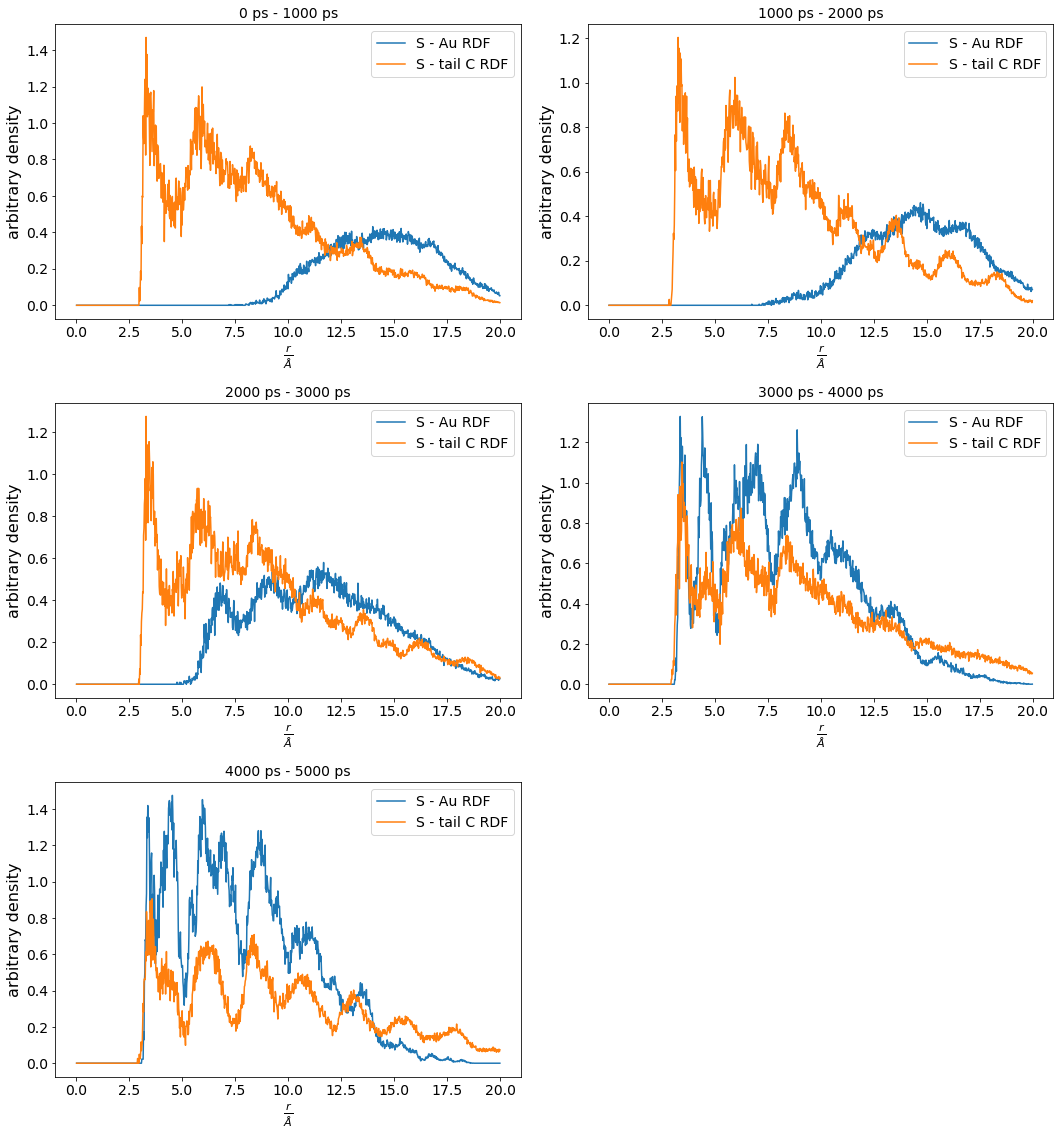

In [176]:
# code snippet for neat plotting of all time-segemtn rdfs
cols = 2
rows = np.ceil(len(rdfSulfurGoldList)/cols).astype(int)
pos = subplotPosition(rows,cols)
fig = plt.figure(figsize=(rows*5,cols*8))

for i, (rdfSulfurGold, rdfTailCarbonGold) in enumerate(zip(rdfSulfurGoldList,rdfTailCarbonGoldList)):
    p = next(pos)
    _, ax = addSubplot(rdf_x,rdfSulfurGold, 
                       legend = "S - Au RDF", 
                       xlabel = r'$\frac{r}{\AA}$', 
                       ylabel='arbitrary density', 
                       title = "{} ps - {} ps".format(i*nSegment,(i+1)*nSegment),
                       fig = fig, pos = p)
    _, _ = addSubplot(rdf_x, rdfTailCarbonGold, 
                      legend="S - tail C RDF",
                      ax = ax, pos = p)
    
fig.tight_layout()

### 4.2. head group sulfur, tail group carbon - water RDF

In [177]:
# Element tuples
element_tuples = [
    ( np.where(chem_sym == 'S')[0][0], np.where(chem_sym == 'O')[0][0] ),
    ( np.where(chem_sym == 'C')[0][0], np.where(chem_sym == 'O')[0][0] ) ]

In [178]:
element_tuples # in atomic numbers

[(16, 8), (6, 8)]

In [179]:
surfactantSolventIndicesOfInterest = water_indices + [ sulfur_index ] + [ tail_carbon_index ]

In [180]:
surfactantSolventRDFs, surfactantSolventRDFx, surfactantSolventRDFobj = piecewiseRDF(
    lmp_trajectrories['npt1ns'], surfactantSolventIndicesOfInterest, element_tuples)

0
1000
2000
3000
4000


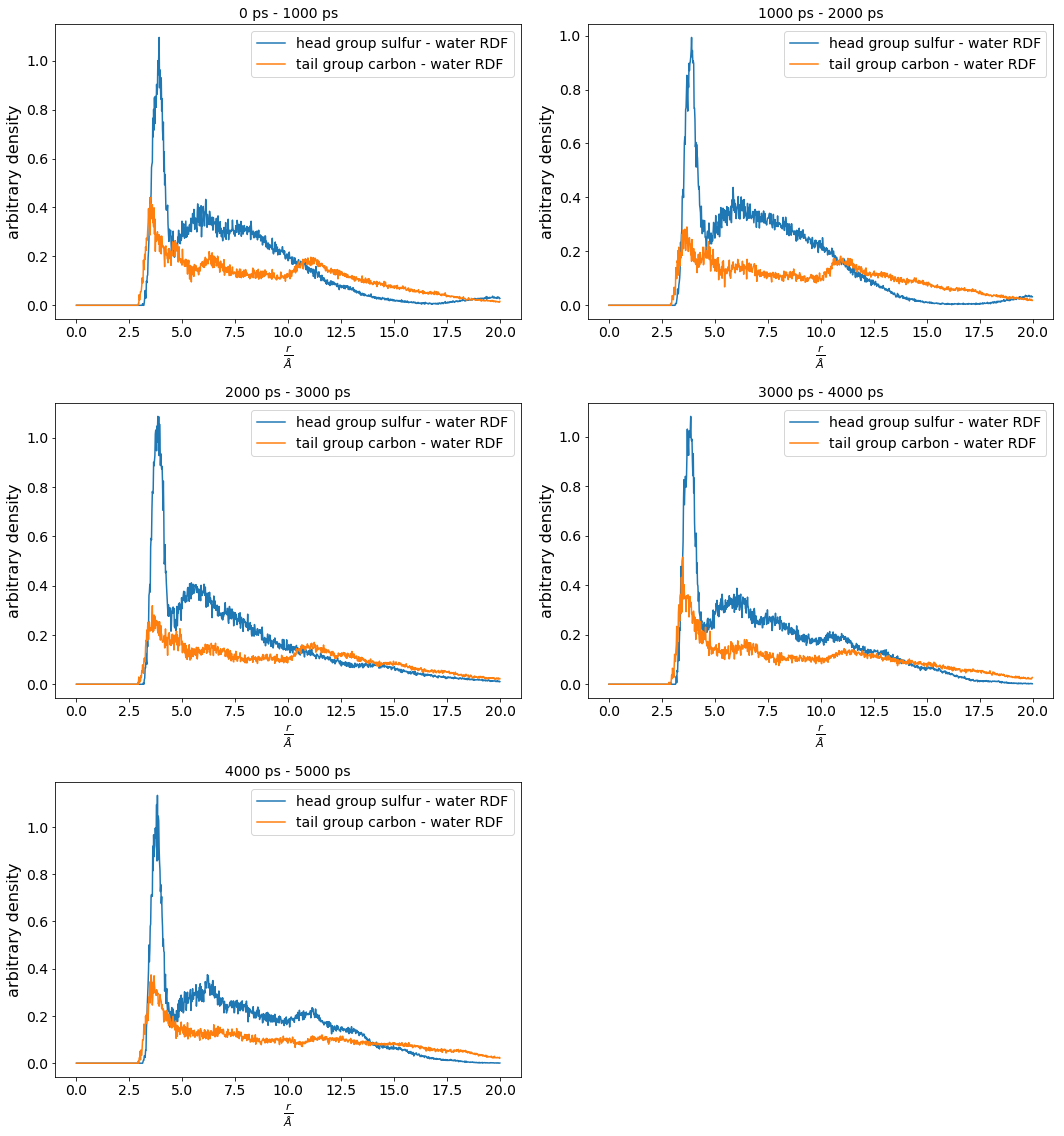

In [181]:
plotPiecewiceRdf(surfactantSolventRDFx, surfactantSolventRDFs, 
                 legend= [ "head group sulfur - water RDF", "tail group carbon - water RDF"]);

### 4.3. Sodium counterion RDF

In [182]:
# Element tuples
counterionRdf_element_tuples = [
    ( np.where(chem_sym == 'Na')[0][0], np.where(chem_sym == 'S')[0][0] ),
    ( np.where(chem_sym == 'Na')[0][0], np.where(chem_sym == 'C')[0][0] ),
    ( np.where(chem_sym == 'Na')[0][0], np.where(chem_sym == 'O')[0][0] ),
    ( np.where(chem_sym == 'Na')[0][0], np.where(chem_sym == 'Au')[0][0] ) ]

In [183]:
counterionRdf_element_tuples

[(11, 16), (11, 6), (11, 8), (11, 79)]

In [184]:
counterionRdfLabels = [ "Na+ counterion - SDS head sulfur RDF", 
                        "Na+ counterion - SDS tail carbon RDF",
                        "Na+ counterion - water oxygen RDF",
                        "Na+ counterion - surface gold RDF"]

In [185]:
counterionRdfIndicesOfInterest = water_indices + surface_indices + \
    ion_indices + [ sulfur_index ] + [ tail_carbon_index ]

In [186]:
counterionRDFs, counterionRDFx, counterionRDFobj = piecewiseRDF(
    lmp_trajectrories['npt1ns'], counterionRdfIndicesOfInterest, counterionRdf_element_tuples)

0
1000
2000
3000
4000


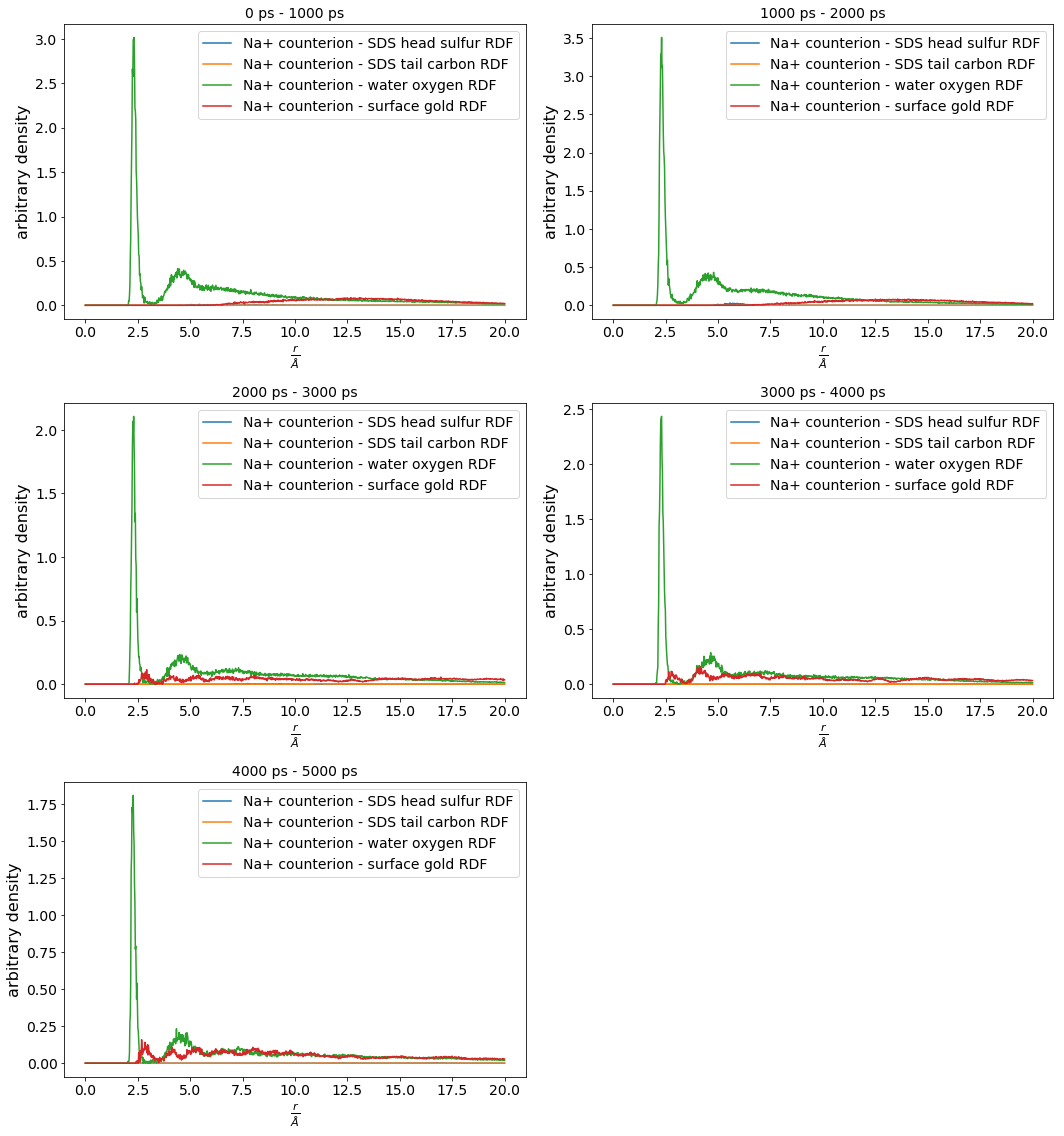

In [187]:
plotPiecewiceRdf(counterionRDFx, counterionRDFs, legend= counterionRdfLabels);

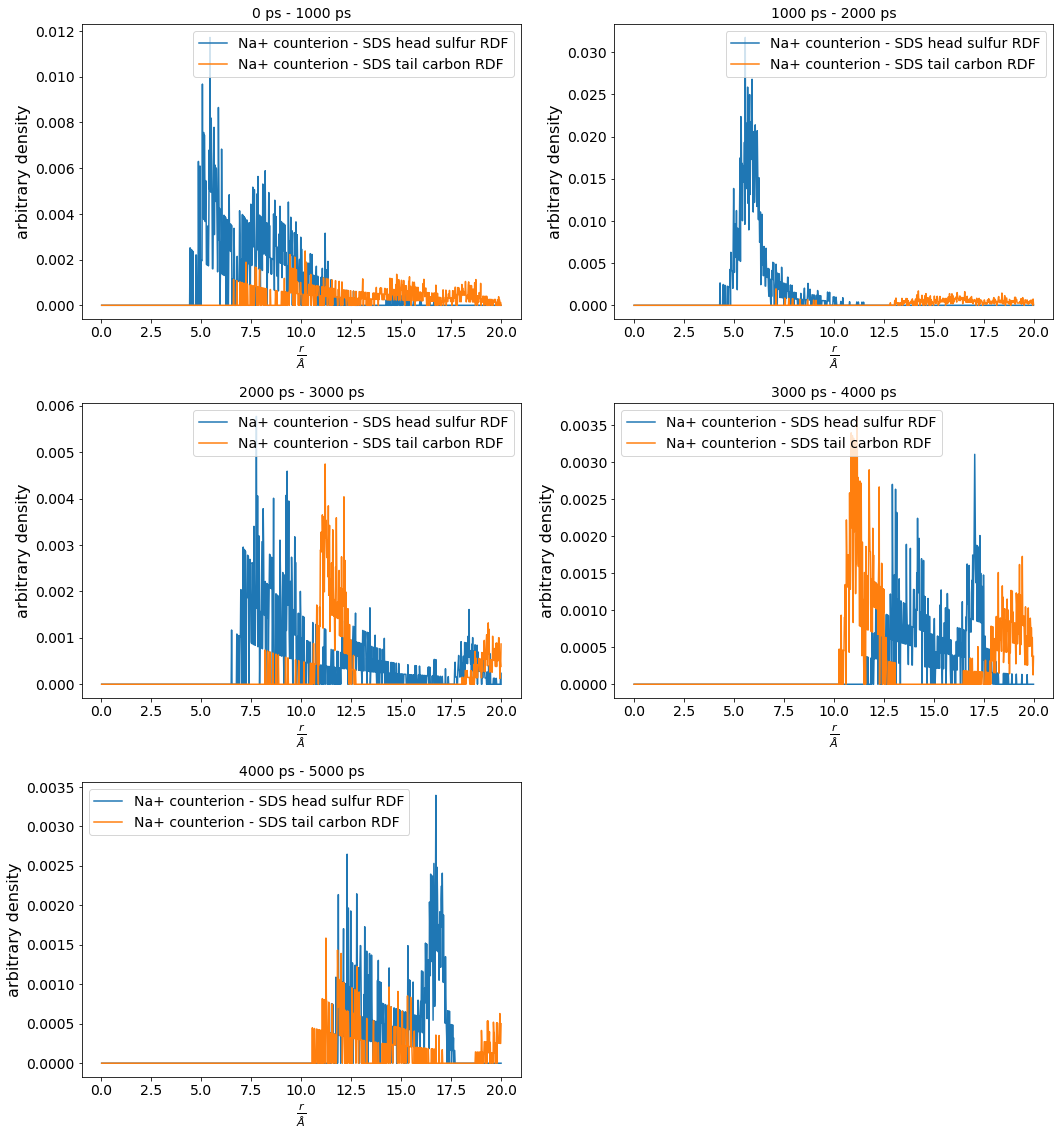

In [189]:
plotPiecewiceRdf(counterionRDFx, counterionRDFs[0:2], 
                 legend= (counterionRdfLabels[0:2]));

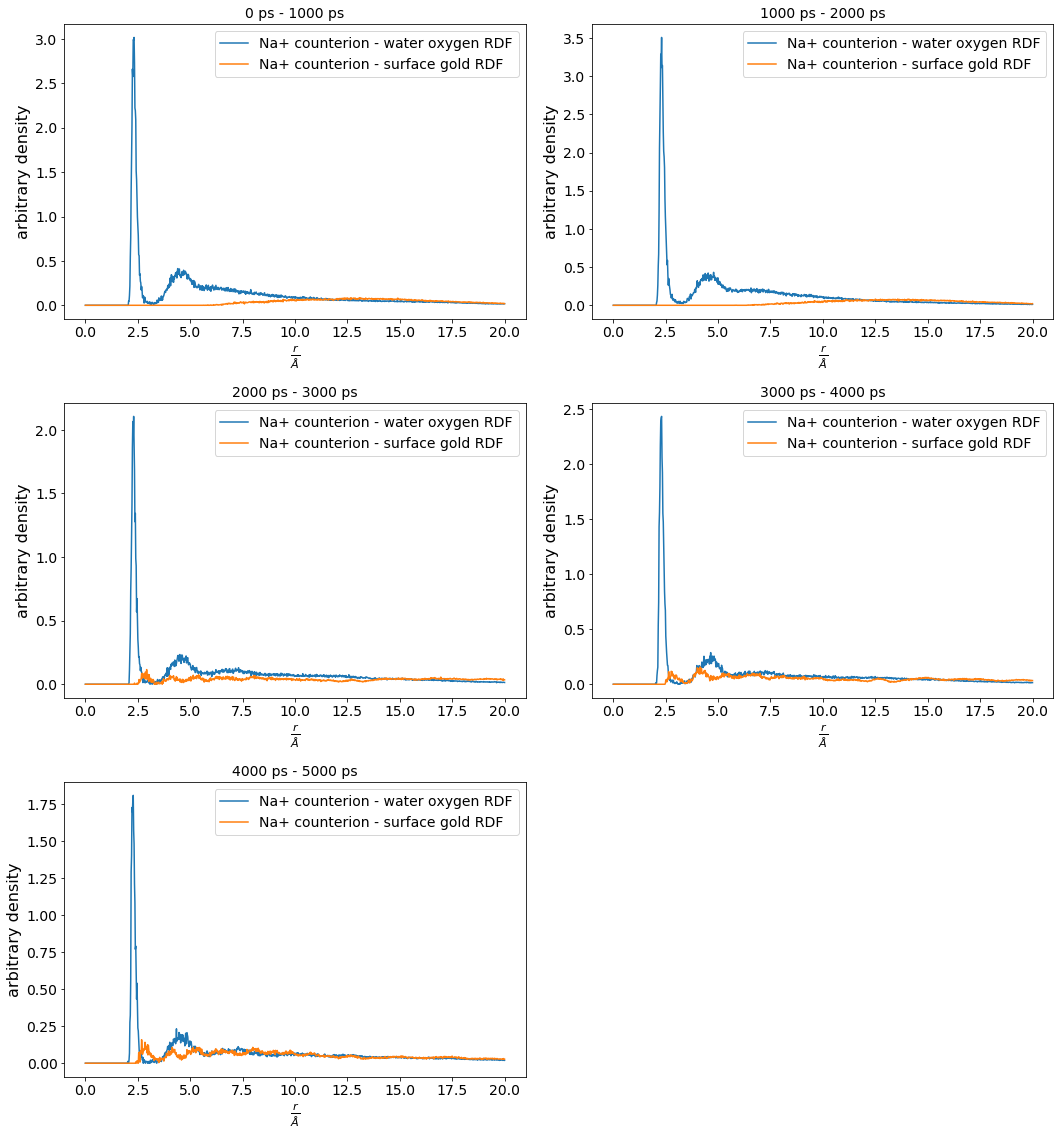

In [190]:
plotPiecewiceRdf(counterionRDFx, counterionRDFs[2:], 
                 legend= (counterionRdfLabels[2:]));

## 5. Distance analysis

### 5.1. Headgroup - gold distance
Head approaches surfaces, apparently "stepwise"

In [191]:
traj = lmp_trajectrories['npt1ns']

In [192]:
traj[0][surfactant_indices].get_atomic_numbers()

array([16,  8,  8, ...,  1,  1,  1])

In [193]:
averageDistanceS2Au, averageDistanceS2AuTimes = piecewiseAveragedDistance(traj,
                                reference_index=sulfur_index,
                                atom_indices=surface_indices,
                                nSegment=50)

In [194]:
len(averageDistanceS2AuTimes)

100

In [195]:
averageDistanceS2Au.shape

(3, 100)

In [196]:
distanceLabels = ['x', 'y', 'z']

Text(0,0.5,'Distance $\\frac{r}{\\AA}$')

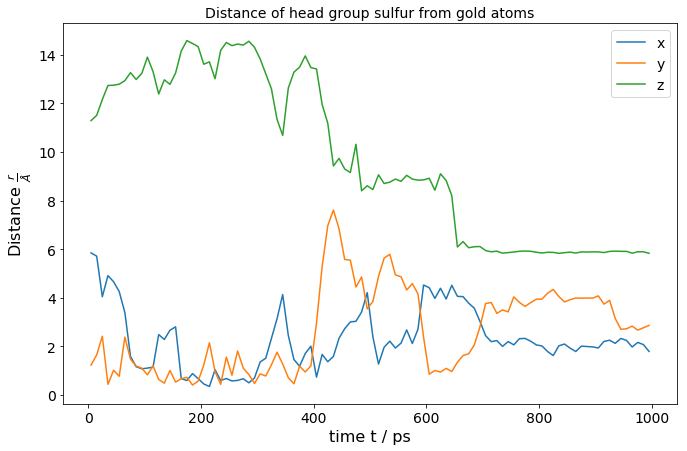

In [197]:
distanceFig = plt.figure()
for i in range(0,3):
    plt.plot( averageDistanceS2AuTimes*0.2, averageDistanceS2Au[i,:], label= distanceLabels[i] )
plt.legend()
plt.title("Distance of head group sulfur from gold atoms")
plt.xlabel("time t / ps")
plt.ylabel(r'Distance $\frac{r}{\AA}$')

In [198]:
traj = lmp_trajectrories['npt1ns']

In [199]:
traj[0][surfactant_indices].get_atomic_numbers()

array([16,  8,  8, ...,  1,  1,  1])

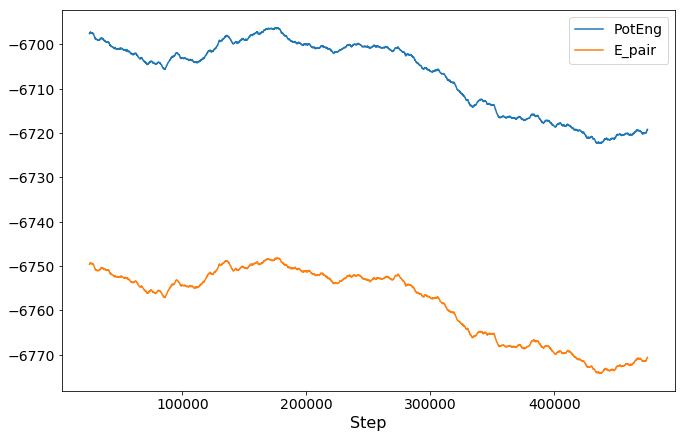

In [201]:
# slight decrease in potential in comparison with approach towards surface
# confirms the anticipated energetically favored adsorption state
nptProduction_1ns_thermo_pd[["PotEng","E_pair"]].rolling(window=5000,center=True).mean().plot()

In [202]:
nptProduction_1ns_thermo_pd

TotEng     KinEng     PotEng       Temp        Press   Enthalpy  \
Step                                                                         
0      -6263.0571  453.10079 -6716.1579  301.79866   798.122940 -6171.1625   
10     -6265.7761  453.21357 -6718.9897  301.87378  -119.442190 -6279.6182   
20     -6263.2673  460.64210 -6723.9094  306.82173   289.621950 -6229.7871   
30     -6267.9400  458.45626 -6726.3962  305.36580 -1420.633000 -6433.0946   
40     -6267.0365  454.66485 -6721.7013  302.84044  1557.912000 -6086.8862   
50     -6267.5204  446.52921 -6714.0497  297.42150  -197.479070 -6290.4505   
60     -6274.3052  436.75049 -6711.0557  290.90815 -1806.958100 -6485.3207   
70     -6274.5247  432.79404 -6707.3187  288.27286  2262.071700 -6012.4026   
80     -6271.3038  432.60558 -6703.9094  288.14733  -767.276420 -6360.7215   
90     -6277.3733  436.87190 -6714.2452  290.98902 -1400.424600 -6440.4945   
100    -6271.7345  461.29208 -6733.0265  307.25467  2055.301600 -6034.5404   
110    -6273.5742  463.61085 -6737.1851  308.79914  -323.591330 -6311.0655   
120    -6276.0452  461.65982 -6737.7050  307.49961  -441.847120 -6327.1367   
130    -6280.6749  459.68075 -6740.3557  306.18140  -637.112930 -6354.4156   
140    -6283.6515  460.93064 -6744.5821  307.01392  1156.133700 -6150.3348   
150    -6287.4721  454.13376 -6741.6059  302.48669  -756.337410 -6374.9679   
160    -6296.9662  452.95837 -6749.9246  301.70380  -801.308860 -6389.5545   
170    -6298.2876  430.20906 -6728.4966  286.55107  1931.707400 -6076.7489   
180    -6302.9410  437.23602 -6740.1770  291.23155 -1420.521800 -6466.9540   
190    -6307.0221  431.59297 -6738.6150  287.47286   915.942100 -6202.1984   
200    -6306.9505  430.02666 -6736.9772  286.42958 -1258.643600 -6452.1378   
210    -6309.5913  420.09868 -6729.6900  279.81681  1169.287600 -6175.6618   
220    -6303.3100  421.50866 -6724.8187  280.75596    72.554129 -6294.9682   
230    -6303.3970  422.26880 -6725.6658  281.26228 -1197.180300 -6441.3359   
240    -6293.9270  423.41199 -6717.3390  282.02372  1159.177500 -6161.0547   
250    -6287.0163  441.90500 -6728.9213  294.34143  -622.037030 -6358.6038   
260    -6278.9437  449.59318 -6728.5368  299.46234     4.150381 -6278.4675   
270    -6270.4279  438.30711 -6708.7350  291.94498   235.898650 -6243.3468   
280    -6260.3922  430.99919 -6691.3914  287.07736   265.349570 -6229.8798   
290    -6251.5076  442.33183 -6693.8394  294.62574    40.789692 -6246.8122   
...           ...        ...        ...        ...          ...        ...   
499710 -6253.0134  437.40051 -6690.4139  291.34111   741.857250 -6165.8642   
499720 -6254.8108  459.86198 -6714.6728  306.30211   181.504630 -6233.5405   
499730 -6259.0044  462.36861 -6721.3730  307.97171 -1675.142400 -6456.5837   
499740 -6262.5737  450.90586 -6713.4796  300.33667  2559.336000 -5963.9443   
499750 -6263.8812  440.69591 -6704.5771  293.53609  -908.432570 -6371.0167   
499760 -6270.7581  426.86339 -6697.6215  284.32261  -494.337360 -6328.8817   
499770 -6271.5294  447.08539 -6718.6148  297.79196   546.610540 -6207.3319   
499780 -6272.5232  445.89931 -6718.4225  297.00194   850.320420 -6172.9345   
499790 -6274.3266  452.19365 -6726.5203  301.19444 -2031.606600 -6513.6513   
499800 -6279.9190  437.87174 -6717.7908  291.65499    14.469685 -6278.2220   
499810 -6273.7231  426.25198 -6699.9751  283.91536  1710.929800 -6073.9294   
499820 -6275.1466  434.14931 -6709.2959  289.17557  -683.052470 -6355.2914   
499830 -6272.3457  446.22269 -6718.5684  297.21734   340.794890 -6232.5669   
499840 -6272.6501  432.20283 -6704.8529  287.87907  -856.983810 -6373.1155   
499850 -6266.1940  444.33626 -6710.5303  295.96083  2374.045800 -5990.7949   
499860 -6263.2341  441.11070 -6704.3448  293.81237 -2625.696400 -6570.8756   
499870 -6264.5047  459.49249 -6723.9971  306.05600   913.565600 -6158.6473   
499880 -6255.2834  449.11794 -6704.4013  299.14579   384.137790 -6210.5924   
499890 -6254.2658  456.27998 -671

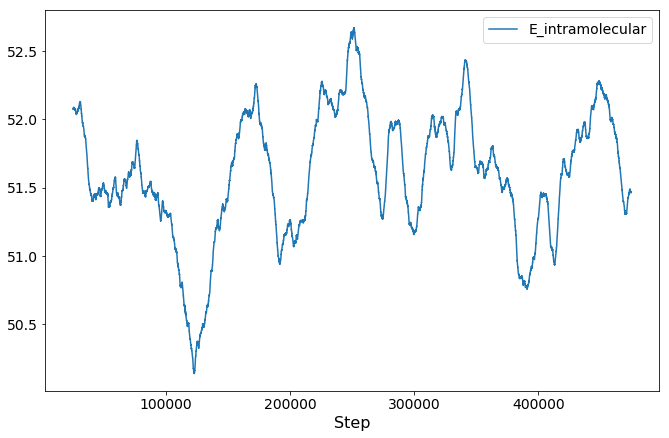

In [203]:
nptProduction_1ns_thermo_pd[["E_intramolecular"]].rolling(window=5000,center=True).mean().plot()

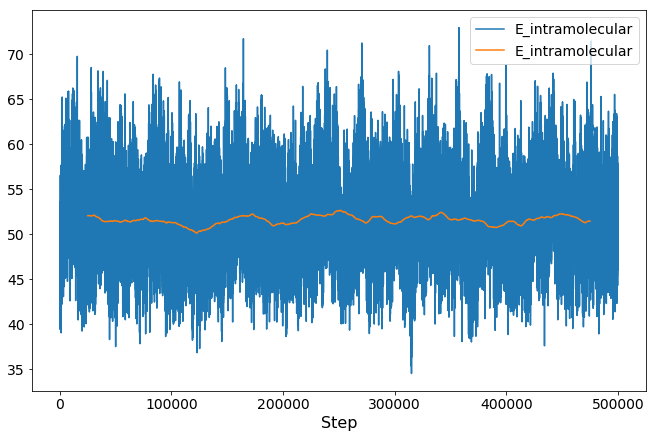

In [204]:
ax = nptProduction_1ns_thermo_pd[["E_intramolecular"]].plot()
nptProduction_1ns_thermo_pd[["E_intramolecular"]].rolling(window=5000,center=True).mean().plot(ax=ax)

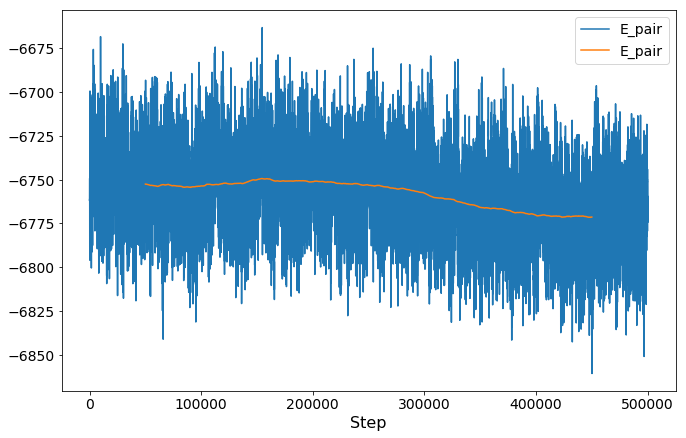

In [205]:
# running average, non-bonded energy
ax = nptProduction_1ns_thermo_pd[["E_pair"]].plot()
nptProduction_1ns_thermo_pd[["E_pair"]].rolling(window=10000,center=True).mean().plot(ax=ax)

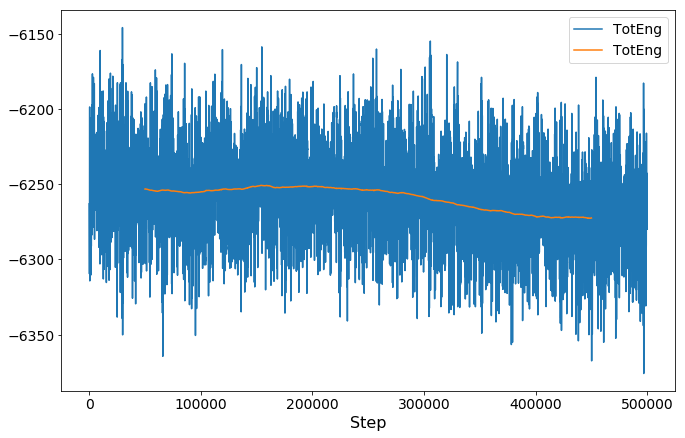

In [206]:
# running average, total energy
ax = nptProduction_1ns_thermo_pd[["TotEng"]].plot()
nptProduction_1ns_thermo_pd[["TotEng"]].rolling(window=10000,center=True).mean().plot(ax=ax)

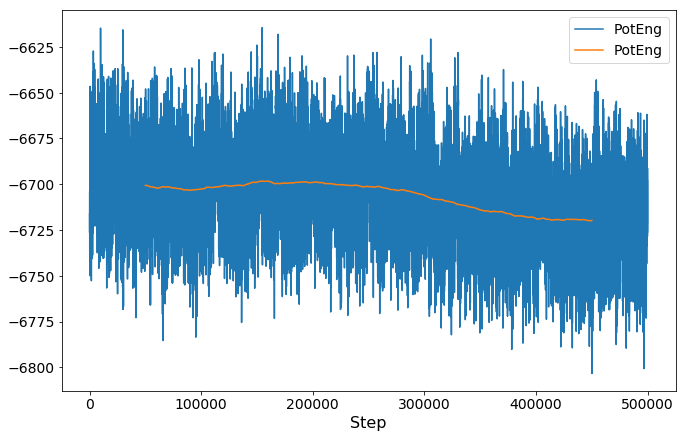

In [207]:
# running average, total energy
ax = nptProduction_1ns_thermo_pd[["PotEng"]].plot()
nptProduction_1ns_thermo_pd[["PotEng"]].rolling(window=10000,center=True).mean().plot(ax=ax)

### 5.2. Tailgroup - gold distance
z - direction: does not change much

In [210]:
averageDistanceTailC2Au, averageDistanceTailC2AuTimes = piecewiseAveragedDistance(traj,
                                reference_index=tail_carbon_index,
                                atom_indices=surface_indices,
                                nSegment=50)

Text(0,0.5,'Distance $\\frac{r}{\\AA}$')

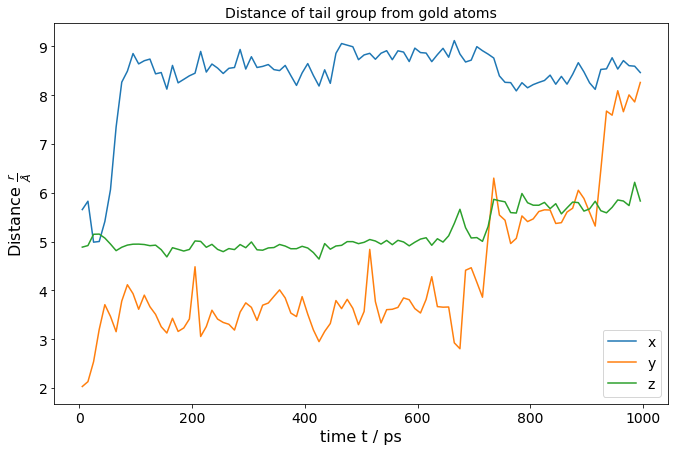

In [211]:
for i in range(0,3):
    plt.plot( averageDistanceTailC2AuTimes*0.2, averageDistanceTailC2Au[i,:], label= distanceLabels[i] )
plt.legend()
plt.title("Distance of tail group from gold atoms")
plt.xlabel("time t / ps")
plt.ylabel(r'Distance $\frac{r}{\AA}$')

### 5.3. Surface COM - Surfactant COM distance

In [212]:
averageDistanceComCom, averageDistanceComComTimes = piecewiseAveragedComComDistance(traj,
                                surfactant_indices,surface_indices,
                                nSegment=50)

Text(0,0.5,'Distance $\\frac{r}{\\AA}$')

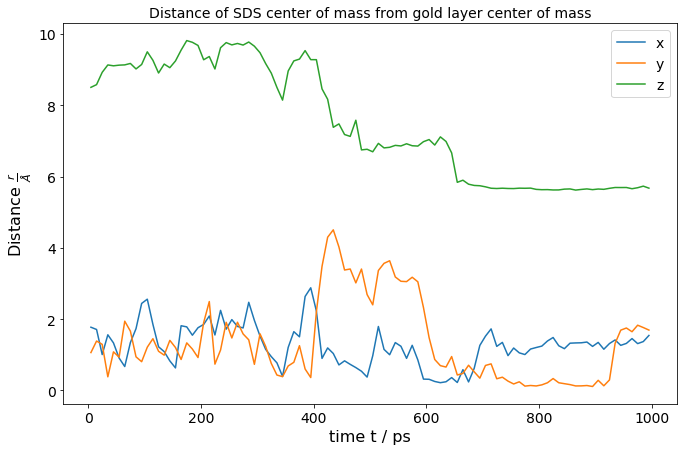

In [213]:
for i in range(0,3):
    plt.plot( averageDistanceComComTimes*0.2, averageDistanceComCom[i,:], label= distanceLabels[i] )
plt.legend()
plt.title("Distance of SDS center of mass from gold layer center of mass")
plt.xlabel("time t / ps")
plt.ylabel(r'Distance $\frac{r}{\AA}$')

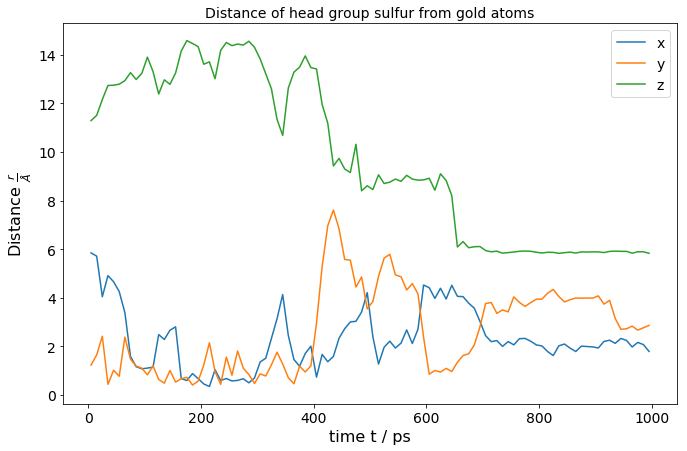

In [215]:
# for comparison: Headgroup - surface distance: 
distanceFig

### SDS chain length

In [216]:
averageChainLength, averageChainLengthTimes = piecewiseAveragedDistance(traj,
                                reference_index=tail_carbon_index,
                                atom_indices=[sulfur_index],
                                nSegment=50)

In [217]:
np.linalg.norm(averageChainLength,axis=0)

array([ 13.19284389,  13.30118302,  11.45347917, ...,  15.15614958,
        15.05356845,  15.03744343])

In [218]:
np.linalg.norm(averageChainLength,axis=0).shape

(100,)

Text(0,0.5,'Distance $\\frac{r}{\\AA}$')

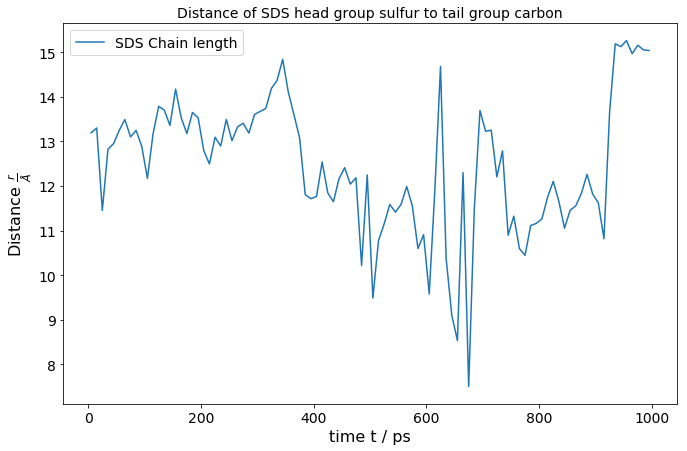

In [219]:
plt.plot( averageChainLengthTimes*0.2, 
         np.linalg.norm(averageChainLength,axis=0), label="SDS Chain length")
plt.legend()
plt.title("Distance of SDS head group sulfur to tail group carbon")
plt.xlabel("time t / ps")
plt.ylabel(r'Distance $\frac{r}{\AA}$')

## MSD and diffusivities

In [220]:
dt

2e-15

In [221]:
T = 1e-9 # 1 ns

In [222]:
Nf = len(traj) - 1 # number of stored frames, corresponds to 1ns

In [223]:
Nf

5000

In [224]:
Ns = T/dt # number of steps

In [225]:
Ns

500000.0

In [226]:
StepsPerFrame = Ns / Nf

In [227]:
StepsPerFrame

100.0

In [228]:
TimePerFrame = StepsPerFrame*dt

In [229]:
TimePerFrame

2e-13

In [235]:
# displacements over fixed time spans, i.e. from each frame to the 50th or 5th following frame

In [230]:
displacement10ps = comDisplacement(traj, surfactant_indices, dt=50)

In [231]:
displacement1ps = comDisplacement(traj, surfactant_indices, dt=5)

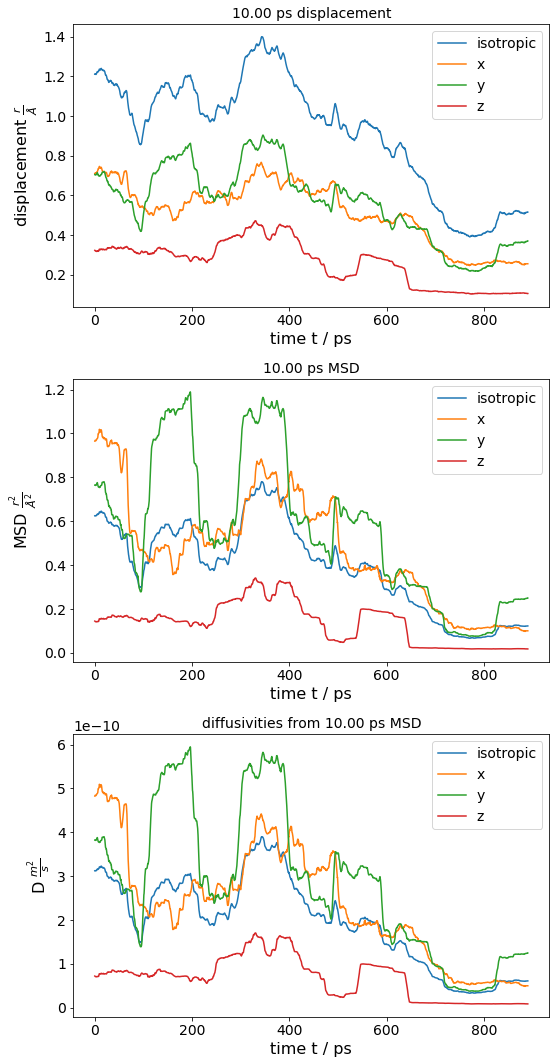

In [232]:
# instead of averaging over many trajectories, we average over N time-wise close frames-frame displacements
# crude (all displacements within each set very correlated)
# default N = 500 ~ 1 ps
evaluateDisplacement(displacement10ps, dt=50);
# however, the results give a good idea about anisotropic and decreasing mobility 
# during approach towards surface

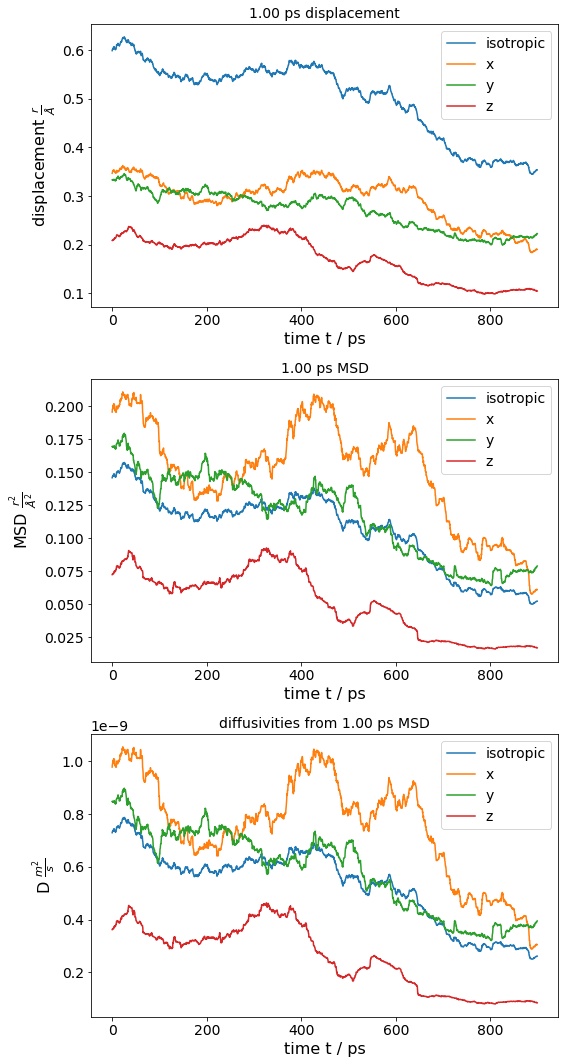

In [233]:
evaluateDisplacement(displacement1ps, dt=5);

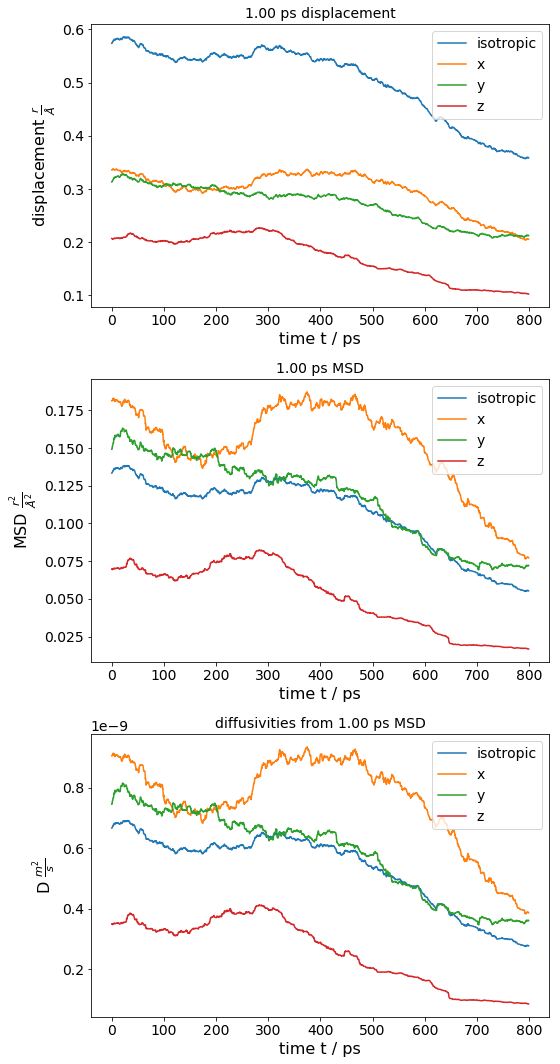

In [234]:
evaluateDisplacement(displacement1ps, dt=5, window=1000);